In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,12)
plt.rcParams['font.size'] = 16
import numpy as np
import seaborn as sns
import xarray as xr

import covid19

## data

In [3]:
istat_path = 'comuni_giornaliero.csv'
_, istat = covid19.data.read_istat(istat_path)

istat_italy = istat.sel(year=2020).sum(['location', 'age_class'])
istat_italy -= istat_italy.sel(time=slice(None, '2020-02-20')).mean()
istat_italy = istat_italy.sel(time=slice(None, '2020-04-30'))
istat_italy

<xarray.DataArray (time: 121)>
array([ 1.34117647e+01,  1.34117647e+01,  4.14117647e+01,  2.41176471e+00,
       -2.55882353e+01,  4.04117647e+01,  2.64117647e+01, -2.58823529e+00,
        9.04117647e+01,  8.94117647e+01, -6.15882353e+01,  2.41176471e+00,
        5.74117647e+01,  7.04117647e+01,  9.41176471e+00,  1.41176471e+00,
        8.74117647e+01,  5.41176471e+00,  4.11764706e-01, -4.58823529e+00,
       -5.58823529e+00,  7.24117647e+01,  7.64117647e+01,  3.74117647e+01,
        7.64117647e+01, -5.85882353e+01,  8.64117647e+01,  8.54117647e+01,
        9.41176471e+00, -4.35882353e+01,  6.41176471e+00, -3.75882353e+01,
       -6.55882353e+01,  3.94117647e+01,  2.24117647e+01, -1.15588235e+02,
       -2.35882353e+01, -4.65882353e+01, -3.05882353e+01, -7.95882353e+01,
       -5.65882353e+01,  1.24117647e+01,  4.54117647e+01, -1.05882353e+01,
        3.84117647e+01, -7.95882353e+01, -1.66588235e+02, -8.65882353e+01,
       -4.15882353e+01,  1.14117647e+01, -1.28588235e+02, -9.15882353e+01,
       -1.43588235e+02, -1.10588235e+02,  7.24117647e+01,  3.34117647e+01,
       -2.15882353e+01, -1.05588235e+02, -2.45882353e+01, -8.65882353e+01,
       -4.25882353e+01,  5.74117647e+01,  7.54117647e+01, -5.95882353e+01,
        9.84117647e+01,  2.25411765e+02,  1.56411765e+02,  2.12411765e+02,
        4.16411765e+02,  5.07411765e+02,  4.97411765e+02,  6.16411765e+02,
        7.44411765e+02,  7.35411765e+02,  7.12411765e+02,  7.93411765e+02,
        9.05411765e+02,  1.10941176e+03,  1.13941176e+03,  1.22141176e+03,
        1.31341176e+03,  1.28941176e+03,  1.31941176e+03,  1.26641176e+03,
        1.31041176e+03,  1.30341176e+03,  1.37041176e+03,  1.33741176e+03,
        1.15341176e+03,  1.17641176e+03,  9.43411765e+02,  9.21411765e+02,
        8.67411765e+02,  8.13411765e+02,  7.69411765e+02,  7.05411765e+02,
        6.94411765e+02,  6.77411765e+02,  6.82411765e+02,  5.44411765e+02,
        5.93411765e+02,  5.81411765e+02,  4.74411765e+02,  5.40411765e+02,
        4.32411765e+02,  3.02411765e+02,  1.90411765e+02,  2.37411765e+02,
        2.35411765e+02,  1.70411765e+02,  2.07411765e+02,  5.34117647e+01,
        2.41176471e+00, -3.25882353e+01, -6.45882353e+01, -3.85882353e+01,
       -9.45882353e+01, -7.75882353e+01, -1.27588235e+02, -1.65588235e+02,
       -2.90588235e+02])
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-04-30
    year     int64 2020

In [102]:
# data_italy_path = 'dpc-covid19-ita-andamento-nazionale.csv'
data_italy_regions_path = 'dpc-covid19-ita-regioni.csv'

In [167]:
# data_italy_path = covid19.data.download('andamento-nazionale')
data_italy_regions_path = covid19.data.download('regioni')

In [168]:
ds_italy_regions = covid19.data.read_dpc(data_italy_regions_path)

ds_italy_regions['mortality'] = ds_italy_regions['deaths'] / ds_italy_regions['population'] * 100_000
ds_italy_regions['daily_deaths'] = ds_italy_regions['deaths'].diff('time')
ds_italy_regions['daily_mortality'] = ds_italy_regions['daily_deaths'] / ds_italy_regions['population'] * 100_000
ds_italy_regions['daily_confirmed'] = ds_italy_regions['confirmed'].diff('time')
ds_italy_regions['daily_tests'] = ds_italy_regions['tests'].diff('time')
ds_italy_regions['diff_current_confirmed'] = ds_italy_regions['current_confirmed'].diff('time')
ds_italy_regions['daily_tested'] = ds_italy_regions['tested'].diff('time')

for kind in ['daily_tests', 'daily_confirmed', 'daily_deaths', 'daily_tested', 'daily_mortality']:
    ds_italy_regions[kind + '7'] = ds_italy_regions[kind].rolling({'time': 7}).mean()

ds_italy_regions = ds_italy_regions.fillna(0)
ds_italy_regions = ds_italy_regions.assign_coords({'location': ('location', [l.partition(' / ')[2] for l in ds_italy_regions.location.values])})
ds_italy_regions = ds_italy_regions.drop(['lat', 'lon', 'state_region'])
ds_italy_regions

<xarray.Dataset>
Dimensions:                 (location: 21, time: 109)
Coordinates:
  * time                    (time) datetime64[ns] 2020-02-24 ... 2020-06-11
  * location                (location) <U21 'Abruzzo' 'Basilicata' ... 'Veneto'
    country                 (location) <U5 'Italy' 'Italy' ... 'Italy' 'Italy'
Data variables:
    current_severe          (time, location) int64 0 0 0 0 10 ... 37 42 11 6 52
    current_critical        (time, location) int64 0 0 0 0 2 0 ... 1 5 15 2 0 0
    deaths                  (time, location) int64 0 0 0 0 ... 1079 76 144 1964
    current_confirmed       (time, location) int64 0 0 0 0 18 ... 521 26 6 922
    confirmed               (time, location) int64 0 0 0 0 ... 1436 1191 19199
    tests                   (time, location) int64 5 0 1 ... 79234 16268 780445
    tested                  (time, location) float64 0.0 0.0 ... 3.641e+05
    dimessi_guariti         (time, location) int64 0 0 0 0 ... 1334 1041 16313
    population              (location) int64 1322247 570365 ... 126883 4907529
    mortality               (time, location) float64 0.0 0.0 0.0 ... 113.5 40.02
    daily_deaths            (time, location) float64 0.0 0.0 0.0 ... 0.0 0.0 3.0
    daily_mortality         (time, location) float64 0.0 0.0 0.0 ... 0.0 0.06113
    daily_confirmed         (time, location) float64 0.0 0.0 0.0 ... 0.0 0.0 5.0
    daily_tests             (time, location) float64 0.0 0.0 ... 127.0 7.129e+03
    diff_current_confirmed  (time, location) float64 0.0 0.0 0.0 ... 0.0 -43.0
    daily_tested            (time, location) float64 0.0 0.0 ... 104.0 1.71e+03
    daily_tests7            (time, location) float64 0.0 0.0 ... 108.0 1.057e+04
    daily_confirmed7        (time, location) float64 0.0 0.0 ... 0.5714 4.429
    daily_deaths7           (time, location) float64 0.0 0.0 ... 0.1429 4.286
    daily_tested7           (time, location) float64 0.0 0.0 ... 64.29 2.802e+03
    daily_mortality7        (time, location) float64 0.0 0.0 ... 0.1126 0.08733

In [169]:
tmp = ds_italy_regions.sortby(-ds_italy_regions['mortality'].isel(time=-1)).isel(time=-1)
REGIONS = list(tmp.location.astype(str).values)
tmp.to_dataframe()

current_severe  current_critical  deaths  \
location                                                          
Lombardia                        2488                97   16374   
Valle d'Aosta                       6                 0     144   
Liguria                           107                 3    1514   
Emilia-Romagna                    216                18    4192   
Piemonte                          544                33    3988   
P.A. Trento                         5                 1     464   
Marche                             26                 0     992   
P.A. Bolzano                        8                 2     292   
Veneto                             52                 0    1964   
Abruzzo                            81                 5     453   
Toscana                            42                15    1079   
Friuli Venezia Giulia              22                 0     342   
Lazio                             320                46     776   
Puglia                             65                 3     530   
Umbria                             11                 2      76   
Sardegna                           10                 1     131   
Molise                              1                 1      23   
Campania                           74                 2     430   
Sicilia                            37                 5     279   
Calabria                           16                 1      97   
Basilicata                          0                 1      27   

                       current_confirmed  confirmed   tests    tested  \
location                                                                
Lombardia                          17340      90932  858994  509853.0   
Valle d'Aosta                          6       1191   16268   12606.0   
Liguria                              250       9864  122654   66755.0   
Emilia-Romagna                      2000      27995  385220  227500.0   
Piemonte                            3183      30958  357957  229096.0   
P.A. Trento                           71       4441   98969   52795.0   
Marche                               902       6751  117720   71531.0   
P.A. Bolzano                          99       2606   74106   35553.0   
Veneto                               922      19199  780445  364110.0   
Abruzzo                              539       3267   87566   59505.0   
Toscana                              521      10158  283638  200500.0   
Friuli Venezia Giulia                112       3287  153763   90508.0   
Lazio                               2517       7889  287888  233158.0   
Puglia                               467       4513  141322   93130.0   
Umbria                                26       1436   79234   56310.0   
Sardegna                              43       1362   66133   56226.0   
Molise                               116        439   17710   16916.0   
Campania                             610       4837  226823  114073.0   
Sicilia                              849       3455  174429  146290.0   
Calabria                              52       1161   79025   76963.0   
Basilicata                            12        401   33957   33167.0   

                       dimessi_guariti  population   mortality  ...  \
location                                                        ...   
Lombardia                        57218    10018806  163.432649  ...   
Valle d'Aosta                     1041      126883  113.490381  ...   
Liguria                           8100     1565307   96.722240  ...   
Emilia-Romagna                   21803     4448841   94.226789  ...   
Piemonte                         23787     4392526   90.790584  ...   
P.A. Trento                       3906      538604   86.148636  ...   
Marche                            4857     1538055   64.497043  ...   
P.A. Bolzano                      2215      524256   55.697980  ...   
Veneto                           16313     4907529   40.020140  ...   
Abruzzo             

In [170]:
ds_italy = ds_italy_regions.sum('location')
ds_italy['mortality'] = ds_italy['deaths'] / ds_italy['population'] * 100_000
ds_italy.to_dataframe().tail(20)

current_severe  current_critical  deaths  current_confirmed  \
time                                                                      
2020-05-23            8695               572   32735              57752   
2020-05-24            8613               553   32785              56594   
2020-05-25            8185               541   32877              55300   
2020-05-26            7917               521   32955              52942   
2020-05-27            7729               505   33072              50966   
2020-05-28            7379               489   33142              47986   
2020-05-29            7094               475   33229              46175   
2020-05-30            6680               450   33340              43691   
2020-05-31            6387               435   33415              42097   
2020-06-01            6099               424   33475              41367   
2020-06-02            5916               408   33530              39893   
2020-06-03            5742               353   33601              39297   
2020-06-04            5503               338   33689              38429   
2020-06-05            5301               316   33774              36976   
2020-06-06            5002               293   33846              35877   
2020-06-07            4864               287   33899              35262   
2020-06-08            4729               283   33964              34730   
2020-06-09            4581               263   34043              32872   
2020-06-10            4320               249   34114              31710   
2020-06-11            4131               236   34167              30637   

            confirmed    tests     tested  dimessi_guariti  population  \
time                                                                     
2020-05-23     229327  3391188  2164426.0           138840    60589085   
2020-05-24     229858  3447012  2198632.0           140479    60589085   
2020-05-25     230158  3482253  2219308.0           141981    60589085   
2020-05-26     230555  3539927  2253252.0           144658    60589085   
2020-05-27     231139  3607251  2290551.0           147101    60589085   
2020-05-28     231732  3683144  2330389.0           150604    60589085   
2020-05-29     232248  3755279  2368622.0           152844    60589085   
2020-05-30     232664  3824621  2404673.0           155633    60589085   
2020-05-31     233019  3878739  2433621.0           157507    60589085   
2020-06-01     233197  3910133  2451674.0           158355    60589085   
2020-06-02     233515  3962292  2477302.0           160092    60589085   
2020-06-03     233836  3999591  2497337.0           160938    60589085   
2020-06-04     234013  4049544  2524788.0           161895    60589085   
2020-06-05     234531  4114572  2565258.0           163781    60589085   
2020-06-06     234801  4187057  2599294.0           165078    60589085   
2020-06-07     234998  4236535  2627188.0           165837    60589085   
2020-06-08     235278  4263647  2643489.0           166584    60589085   
2020-06-09     235561  4318650  2675689.0           168646    60589085   
2020-06-10     235763  4381349  2713554.0           169939    60589085   
2020-06-11     236142  4443821  2746545.0           171338    60589085   

            mortality  ...  daily_mortality  daily_confirmed  daily_tests  \
time                   ...                                                  
2020-05-23  54.027883  ...         2.669547            669.0      72410.0   
2020-05-24  54.110406  ...         1.914674            531.0      55824.0   
2020-05-25  54.262249  ...         2.181168            300.0      35241.0   
2020-05-26  54.390985  ...         2.285655            397.0      57674.0   
2020-05-27  54.584089  ...         2.438454            584.0      67324.0   
2020-05-28  54.699621  ...         1.828596            593.0      75893.0   
2020-05-29  54.843211  ...         1.454135            516.0      72135.0   
2020-05-30  55.026413  ...         1.95

## situation report

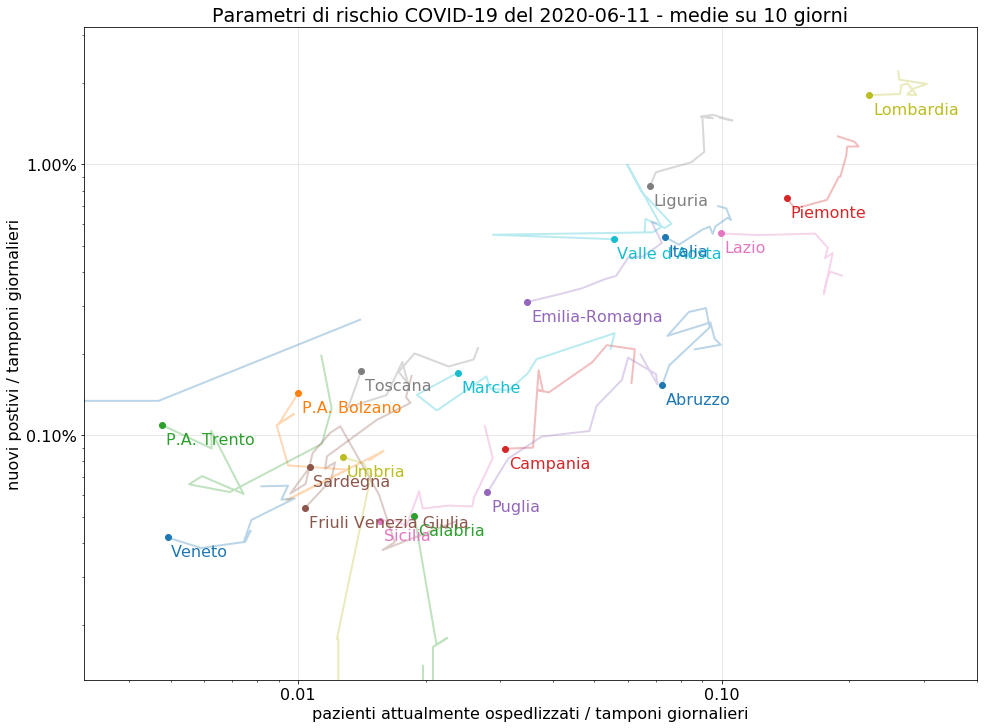

In [171]:
window = 10
rr = ds_italy_regions.isel(time=slice(-window, None))
var = rr['daily_confirmed7'] / np.maximum(rr['daily_tests7'], 1)
var1 = ds_italy_regions['current_severe'] / np.maximum(rr['daily_tests7'], 1)

it_var = (rr['daily_confirmed7'].sum('location') / np.maximum(rr['daily_tests7'], 1).sum('location')).expand_dims(location=['Italia'])
it_var1 = (ds_italy_regions['current_severe'].sum('location') / np.maximum(rr['daily_tests7'], 1).sum('location')).expand_dims(location=['Italia'])


_, ax = plt.subplots()
ax.yaxis.grid(color="lightgrey", linewidth=0.5)
ax.xaxis.grid(color="lightgrey", linewidth=0.5)

# ax.fill([0, 0.2, 0.2, 0], [0, 0, 0.016, 0.016], 'green', alpha=0.03)
# ax.fill([0, 0.05, 0.05, 0], [0, 0, 0.004, 0.004], 'green', alpha=0.03)
# ax.fill([0, 0.0125, 0.0125, 0], [0, 0, 0.001, 0.001], 'green', alpha=0.03)

xlim = (0.003125, 0.4)
ylim = (0.000125, 0.032)

covid19.plot.scatter_xarray(var1, var, ax=ax, xlim=xlim, ylim=ylim)
covid19.plot.scatter_xarray(it_var1, it_var, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(
    xscale='log',
    yscale='log',
    xlim=xlim, ylim=ylim,
    title=f'Parametri di rischio COVID-19 del {str(var1.time.max().values)[:10]} - medie su {window} giorni',
    xlabel='pazienti attualmente ospedlizzati / tamponi giornalieri',
    ylabel='nuovi postivi / tamponi giornalieri',
)
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
# x = np.arange(1000) * .001
# ax.plot(x, 0.08 * x )

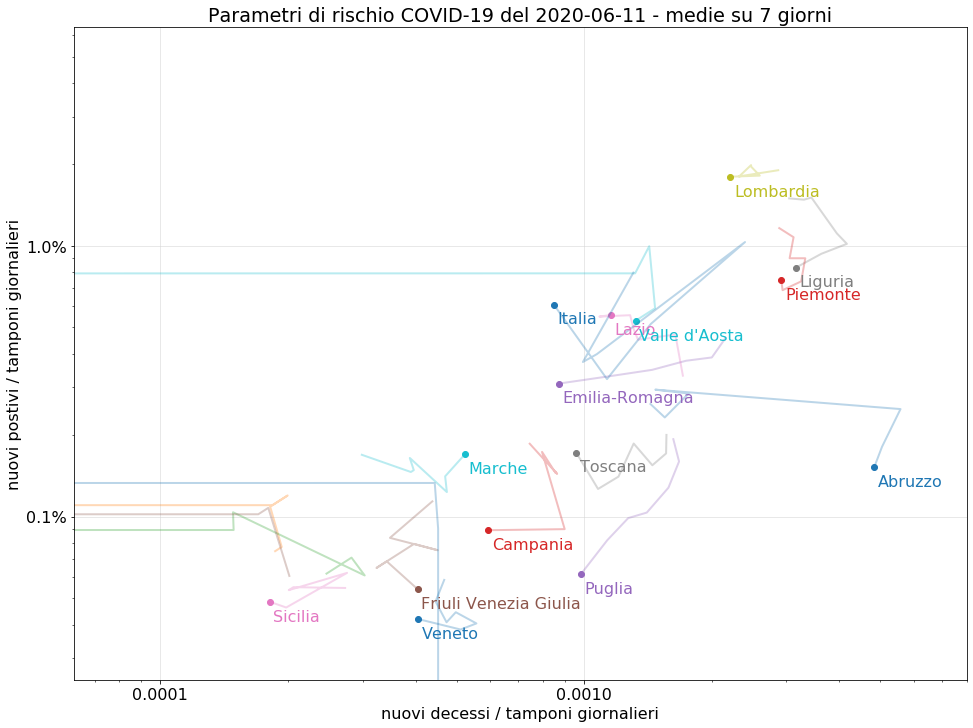

In [155]:
window = 7
rr = ds_italy_regions.isel(time=slice(-window, None))
var = rr['daily_confirmed7'] / np.maximum(rr['daily_tests7'], 1)
var1 = rr['daily_deaths7'] / np.maximum(rr['daily_tests7'], 1)

it_var = (rr['daily_confirmed'].sum('location') / np.maximum(rr['daily_tests'], 1).sum('location')).expand_dims(location=['Italia'])
it_var1 = (rr['daily_deaths'].sum('location') / np.maximum(rr['daily_tests'], 1).sum('location')).expand_dims(location=['Italia'])


_, ax = plt.subplots()
ax.yaxis.grid(color="lightgrey", linewidth=0.5)
ax.xaxis.grid(color="lightgrey", linewidth=0.5)

# ax.fill([0, 0.2, 0.2, 0], [0, 0, 0.016, 0.016], 'green', alpha=0.03)
# ax.fill([0, 0.05, 0.05, 0], [0, 0, 0.004, 0.004], 'green', alpha=0.03)
# ax.fill([0, 0.0125, 0.0125, 0], [0, 0, 0.001, 0.001], 'green', alpha=0.03)

xlim = (0.0000625, 0.008)
ylim = (0.00025, 0.064)

covid19.plot.scatter_xarray(var1, var, ax=ax, xlim=xlim, ylim=ylim)
covid19.plot.scatter_xarray(it_var1, it_var, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(
    xscale='log',
    yscale='log',
    xlim=xlim, ylim=ylim,
    title=f'Parametri di rischio COVID-19 del {str(var1.time.max().values)[:10]} - medie su {window} giorni',
    xlabel='nuovi decessi / tamponi giornalieri',
    ylabel='nuovi postivi / tamponi giornalieri',
)
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.4f'))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
# x = np.arange(1000) * .001
# ax.plot(x, 0.08 * x )

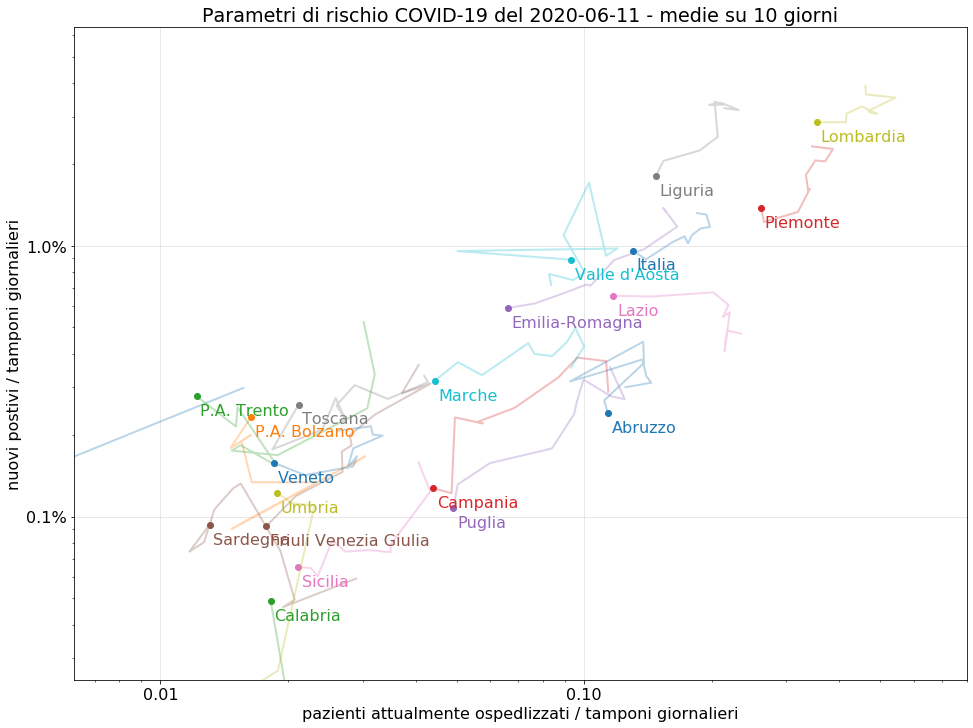

In [156]:
window = 10
rr = ds_italy_regions.isel(time=slice(-window, None))
var = rr['daily_confirmed7'] / np.maximum(rr['daily_tested7'], 1)
var1 = ds_italy_regions['current_severe'] / np.maximum(rr['daily_tested7'], 1)

it_var = (rr['daily_confirmed7'].sum('location') / np.maximum(rr['daily_tested7'], 1).sum('location')).expand_dims(location=['Italia'])
it_var1 = (ds_italy_regions['current_severe'].sum('location') / np.maximum(rr['daily_tested7'], 1).sum('location')).expand_dims(location=['Italia'])


_, ax = plt.subplots()
ax.yaxis.grid(color="lightgrey", linewidth=0.5)
ax.xaxis.grid(color="lightgrey", linewidth=0.5)

# ax.fill([0, 0.2, 0.2, 0], [0, 0, 0.016, 0.016], 'green', alpha=0.03)
# ax.fill([0, 0.05, 0.05, 0], [0, 0, 0.004, 0.004], 'green', alpha=0.03)
# ax.fill([0, 0.0125, 0.0125, 0], [0, 0, 0.001, 0.001], 'green', alpha=0.03)

xlim = (0.00625, 0.8)
ylim = (0.00025, 0.064)

covid19.plot.scatter_xarray(var1, var, ax=ax, xlim=xlim, ylim=ylim)
covid19.plot.scatter_xarray(it_var1, it_var, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(
    xscale='log',
    yscale='log',
    xlim=xlim, ylim=ylim,
    title=f'Parametri di rischio COVID-19 del {str(var1.time.max().values)[:10]} - medie su {window} giorni',
    xlabel='pazienti attualmente ospedlizzati / tamponi giornalieri',
    ylabel='nuovi postivi / tamponi giornalieri',
)
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
# x = np.arange(1000) * .001
# ax.plot(x, 0.08 * x )

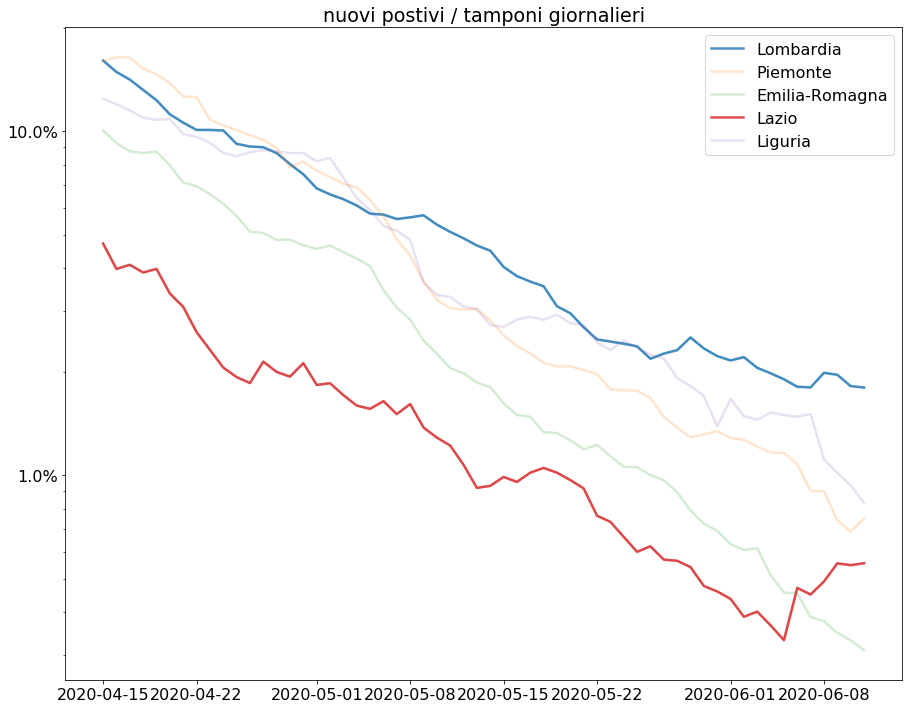

In [157]:
_, ax = plt.subplots(figsize=(15,12))
ax.set(yscale='log', title='nuovi postivi / tamponi giornalieri')
data = ds_italy_regions['daily_confirmed7'] / ds_italy_regions['daily_tests7']
covid19.plot.plot_xarray(data.sel(location=['Lombardia', 'Piemonte', 'Emilia-Romagna', 'Lazio', 'Liguria'], time=slice('2020-04-15', None)), hue='location', foreground_hue=['Lombardia', 'Lazio'], ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
_ = ax.legend()

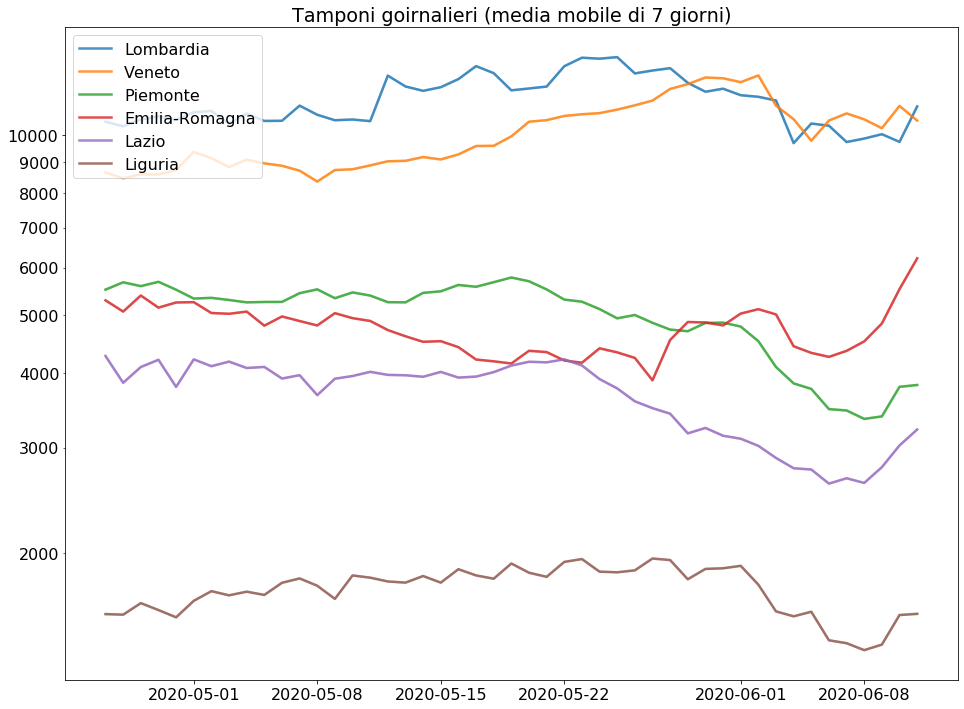

In [158]:
_, ax = plt.subplots()
ax.set(yscale='log', title='Tamponi goirnalieri (media mobile di 7 giorni)')
data = ds_italy_regions['daily_tests7']
covid19.plot.plot_xarray(data.sel(location=['Lombardia', 'Veneto', 'Piemonte', 'Emilia-Romagna', 'Lazio', 'Liguria'], time=slice('2020-04-26', None)), hue='location', ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
_ = ax.legend(loc='upper left')

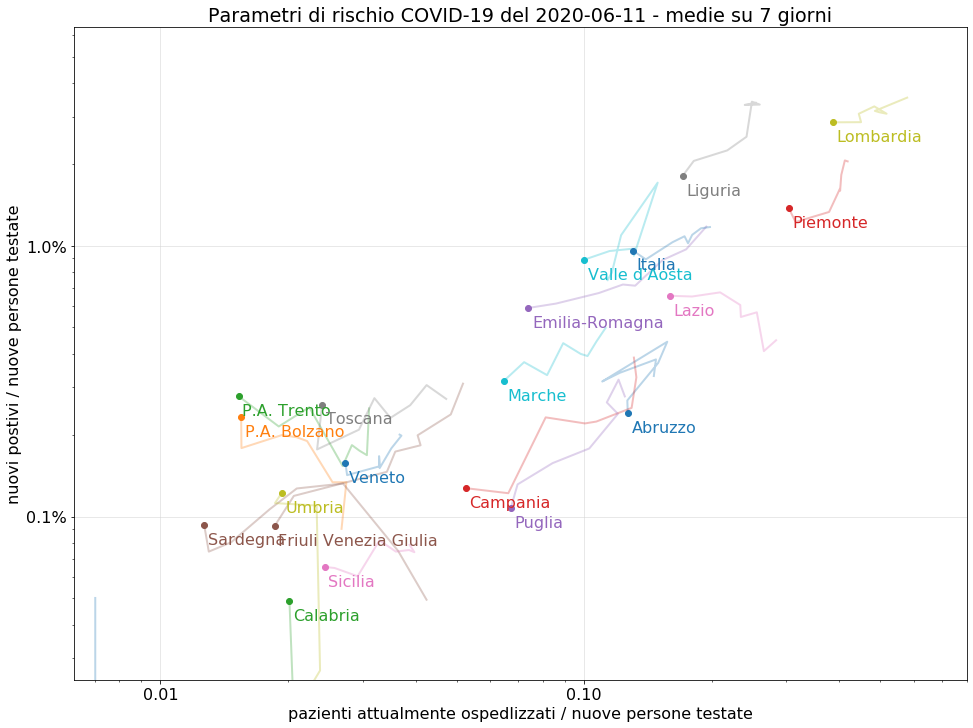

In [159]:
window = 7
rr = ds_italy_regions.isel(time=slice(-(window + 7), None)).rolling({'time': window}).mean().dropna('time')
rrr = ds_italy_regions
var = rr['daily_confirmed'] / np.maximum(rr['daily_tested'], 1)
var1 = rr['current_severe'] / np.maximum(rr['daily_tested'], 1)

it_var = (rr['daily_confirmed'].sum('location') / np.maximum(rr['daily_tested'], 1).sum('location')).expand_dims(location=['Italia'])
it_var1 = (rrr['current_severe'].sum('location') / np.maximum(rr['daily_tested'], 1).sum('location')).expand_dims(location=['Italia'])


_, ax = plt.subplots()
ax.yaxis.grid(color="lightgrey", linewidth=0.5)
ax.xaxis.grid(color="lightgrey", linewidth=0.5)

# ax.fill([0, 0.2, 0.2, 0], [0, 0, 0.016, 0.016], 'green', alpha=0.03)
# ax.fill([0, 0.05, 0.05, 0], [0, 0, 0.004, 0.004], 'green', alpha=0.03)
# ax.fill([0, 0.0125, 0.0125, 0], [0, 0, 0.001, 0.001], 'green', alpha=0.03)
   
xlim = (0.00625, 0.8)
ylim = (0.00025, 0.064)

covid19.plot.scatter_xarray(var1, var, ax=ax, xlim=xlim, ylim=ylim)
covid19.plot.scatter_xarray(it_var1, it_var, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(
    xscale='log',
    yscale='log',
    xlim=xlim, ylim=ylim,
    title=f'Parametri di rischio COVID-19 del {str(var1.time.max().values)[:10]} - medie su {window} giorni',
    xlabel='pazienti attualmente ospedlizzati / nuove persone testate',
    ylabel='nuovi postivi / nuove persone testate',
)
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
# x = np.arange(1000) * .001
# ax.plot(x, 0.08 * x )

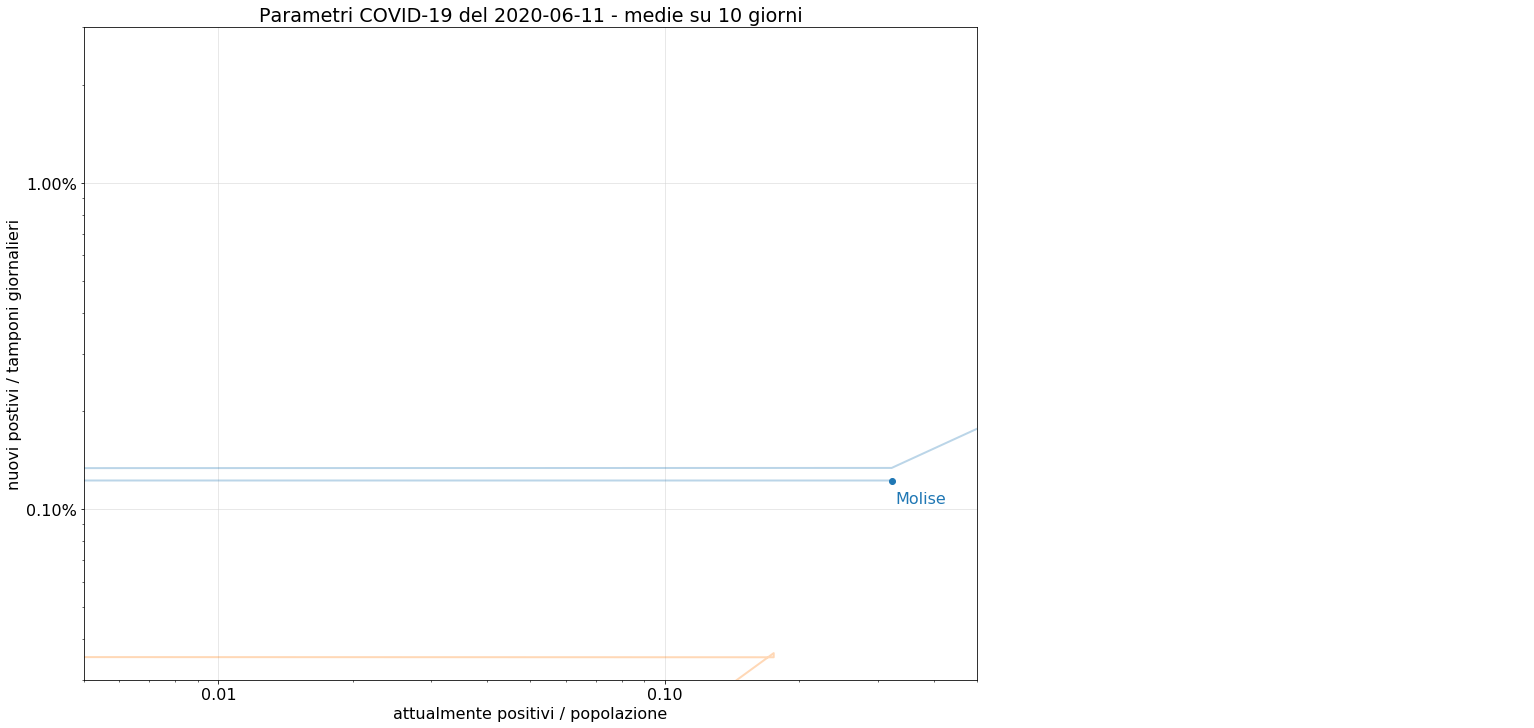

In [160]:
window = 10
rr = ds_italy_regions.isel(time=slice(-window, None))
var = rr['daily_confirmed7'] / np.maximum(rr['daily_tests7'], 1)
var1 = ds_italy_regions['current_severe'] / np.maximum(rr['population'], 1) * 100_000

it_var = (rr['daily_confirmed7'].sum('location') / np.maximum(rr['daily_tests7'], 1).sum('location')).expand_dims(location=['Italia'])
it_var1 = (ds_italy_regions['current_severe'].sum('location') / np.maximum(rr['population'], 1).sum('location')).expand_dims(location=['Italia'])* 100_000


_, ax = plt.subplots()
ax.yaxis.grid(color="lightgrey", linewidth=0.5)
ax.xaxis.grid(color="lightgrey", linewidth=0.5)

# ax.fill([0, 0.2, 0.2, 0], [0, 0, 0.016, 0.016], 'green', alpha=0.03)
# ax.fill([0, 0.05, 0.05, 0], [0, 0, 0.004, 0.004], 'green', alpha=0.03)
# ax.fill([0, 0.0125, 0.0125, 0], [0, 0, 0.001, 0.001], 'green', alpha=0.03)

xlim = (0.005, 0.5)
ylim = (0.0003, 0.03)

covid19.plot.scatter_xarray(var1, var, ax=ax, xlim=xlim, ylim=ylim)
covid19.plot.scatter_xarray(it_var1, it_var, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(
    xscale='log',
    yscale='log',
    xlim=xlim, ylim=ylim,
    title=f'Parametri COVID-19 del {str(var1.time.max().values)[:10]} - medie su {window} giorni',
    xlabel='attualmente positivi / popolazione',
    ylabel='nuovi postivi / tamponi giornalieri',
)
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
# x = np.arange(1000) * .001
# ax.plot(x, 0.08 * x )

In [172]:
ds_italy_regions.sel(location="P.A. Trento").to_dataframe()[['location', 'current_severe', 'current_critical', 'daily_tests', 'daily_confirmed', 'daily_deaths', 'daily_tested', 'daily_tests7', 'daily_confirmed7', 'daily_deaths7', 'daily_tested7']].tail(20)


location  current_severe  current_critical  daily_tests  \
time                                                                     
2020-05-23  P.A. Trento              28                 4       2184.0   
2020-05-24  P.A. Trento              27                 4       1603.0   
2020-05-25  P.A. Trento              27                 4        666.0   
2020-05-26  P.A. Trento              24                 3        695.0   
2020-05-27  P.A. Trento              19                 2       1120.0   
2020-05-28  P.A. Trento              17                 3        749.0   
2020-05-29  P.A. Trento              16                 3       1787.0   
2020-05-30  P.A. Trento              13                 3       1760.0   
2020-05-31  P.A. Trento              13                 3       1993.0   
2020-06-01  P.A. Trento              14                 3        677.0   
2020-06-02  P.A. Trento              14                 2        552.0   
2020-06-03  P.A. Trento              15                 2       1234.0   
2020-06-04  P.A. Trento              14                 1        610.0   
2020-06-05  P.A. Trento               8                 1       1285.0   
2020-06-06  P.A. Trento               6                 1       1243.0   
2020-06-07  P.A. Trento               6                 1       1479.0   
2020-06-08  P.A. Trento               7                 1        187.0   
2020-06-09  P.A. Trento               6                 1        702.0   
2020-06-10  P.A. Trento               6                 1       1212.0   
2020-06-11  P.A. Trento               5                 1       1230.0   

            daily_confirmed  daily_deaths  daily_tested  daily_tests7  \
time                                                                    
2020-05-23              7.0           1.0        1419.0   1828.857143   
2020-05-24              9.0           1.0         556.0   1447.000000   
2020-05-25              1.0           1.0        -329.0   1468.714286   
2020-05-26             10.0           3.0         395.0   1494.000000   
2020-05-27              7.0           1.0         424.0   1462.571429   
2020-05-28              3.0           0.0         385.0   1309.857143   
2020-05-29              3.0           0.0         614.0   1257.714286   
2020-05-30              1.0           0.0         559.0   1197.142857   
2020-05-31              1.0           0.0         757.0   1252.857143   
2020-06-01              2.0           0.0         188.0   1254.428571   
2020-06-02              0.0           1.0         320.0   1234.000000   
2020-06-03              1.0           0.0         453.0   1250.285714   
2020-06-04              0.0           1.0         294.0   1230.428571   
2020-06-05              0.0           0.0         392.0   1158.714286   
2020-06-06              1.0           0.0         446.0   1084.857143   
2020-06-07              1.0           0.0         627.0   1011.428571   
2020-06-08              1.0           0.0          68.0    941.428571   
2020-06-09              3.0           0.0         481.0    962.857143   
2020-06-10              0.0           0.0         478.0    959.714286   
2020-06-11              2.0           0.0         383.0   1048.285714   

            daily_confirmed7  daily_deaths7  daily_tested7  
time                                                        
2020-05-23          9.857143       0.428571     813.000000  
2020-05-24          9.428571       0.571429     639.571429  
2020-05-25          7.714286       0.714286     592.571429  
2020-05-26          8.142857       0.857143     543.000000  
2020-05-27          7.714286       1.000000     601.428571  
2020-05-28          6.714286       1.000000     540.142857  
2020-05-29          5.714286       1.000000     494.857143  
2020-05-30          4.857143       0.857143     372.000000  
2020-05-31          3.714286       0.714286     400.714286  
2020-06-01          3.857143       0.571429     474.571429  
2020-06-02          2.428571       0.285714    

21

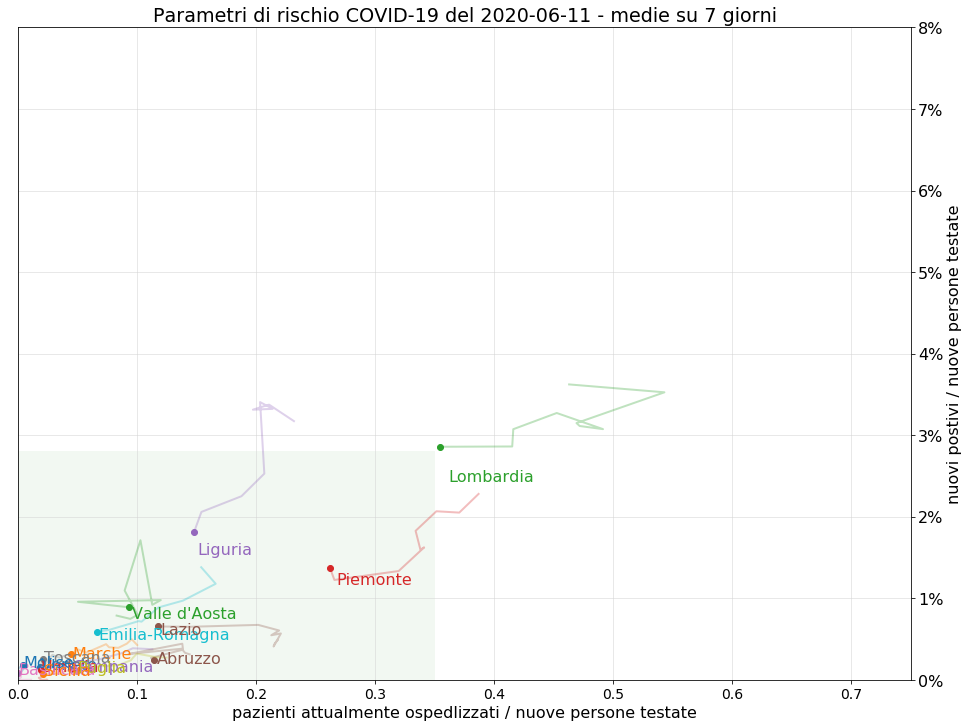

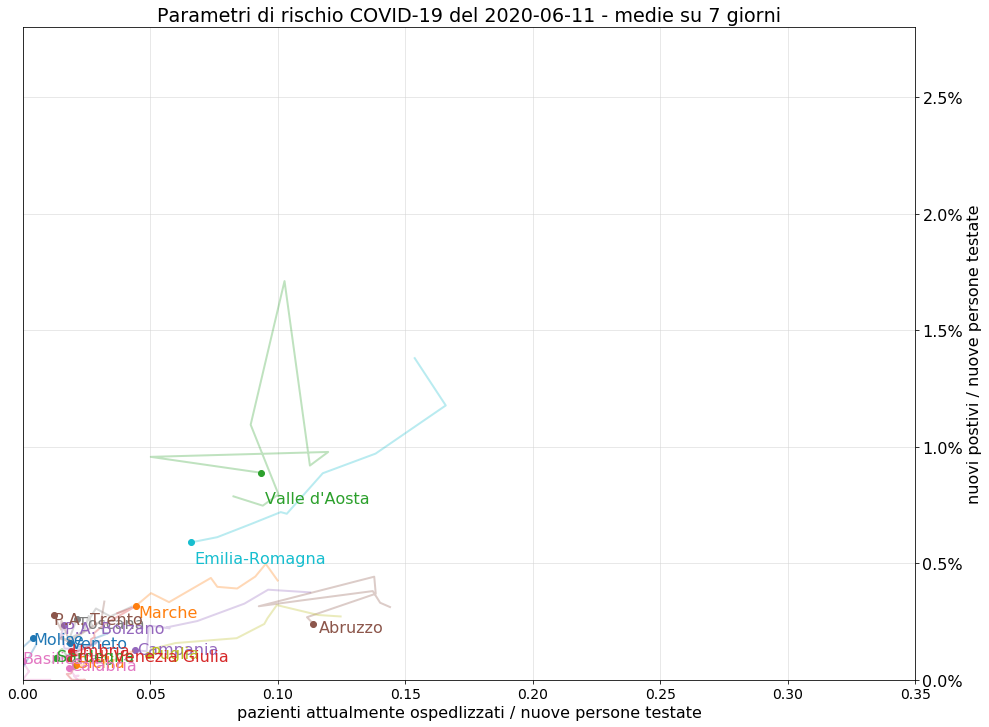

In [162]:
window = 7
rr = ds_italy_regions.isel(time=slice(-(window + 8), None)).rolling({'time': window}).mean().dropna('time')
it_rr = rr.sum('location')
rrr = ds_italy_regions
it_rrr = rrr.sum('location')
var = rr['daily_confirmed'] / np.maximum(rr['daily_tested'], 1)
it_var = it_rr['daily_confirmed'] / np.maximum(it_rr['daily_tested'], 1)
var1 = rrr['current_severe'] / np.maximum(rr['daily_tested'], 1)
it_var1 = it_rrr['current_severe'] / np.maximum(it_rr['daily_tested'], 1)
var2 = ((rrr['current_severe'] + rrr['current_critical']) / np.maximum(rrr['current_confirmed'], 1))

b = ['Veneto', 'Marche', "Valle d'Aosta", 'Umbria', 'Campania', 'Abruzzo', 'Basilicata', 'Toscana', 'Puglia', 'Emilia-Romagna', 'Molise', 'Sicilia']
r =  b + ['Lombardia', 'Piemonte', 'Liguria', 'Lazio']
_, ax = covid19.plot.subplots()
ax.fill([0, 0.35, 0.35, 0], [0, 0, 0.028, 0.028], 'green', alpha=0.05)
covid19.plot.scatter_xarray(var1.sel(location=r), var, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=0))
_ = ax.set(
    title=f'Parametri di rischio COVID-19 del {str(var1.time.max().values)[:10]} - medie su {window} giorni',
    ylim=(0., 0.08), xlim=(0., 0.75),
    xlabel='pazienti attualmente ospedlizzati / nuove persone testate',
    ylabel='nuovi postivi / nuove persone testate',
)

rs = b + ['Sardegna', 'Friuli Venezia Giulia', 'P.A. Bolzano', 'P.A. Trento', 'Calabria']
ax = covid19.plot.scatter_xarray(var1.sel(location=rs), var)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1., decimals=1))
_ = ax.set(
    title=f'Parametri di rischio COVID-19 del {str(var1.time.max().values)[:10]} - medie su {window} giorni',
    ylim=(0., 0.028), xlim=(0., 0.35),
    xlabel='pazienti attualmente ospedlizzati / nuove persone testate',
    ylabel='nuovi postivi / nuove persone testate',
)

len(set(r) | set(rs))
#rr['current_severe'].isel(time=-1)

In [163]:
tmp = ds_italy_regions.sel(location='Lazio').to_dataframe()
tmp['tpr'] = tmp['daily_confirmed'] / tmp['daily_tests']
tmp['tpr7'] = tmp['daily_confirmed7'] / tmp['daily_tests7']
tmp.tail(12)

current_severe  current_critical  deaths  current_confirmed  \
time                                                                      
2020-05-31             730                57     735               2983   
2020-06-01             594                56     739               2894   
2020-06-02             580                56     741               2847   
2020-06-03             519                51     747               2818   
2020-06-04             488                51     750               2754   
2020-06-05             480                51     754               2710   
2020-06-06             477                49     758               2697   
2020-06-07             467                49     760               2690   
2020-06-08             466                49     763               2615   
2020-06-09             462                47     766               2570   
2020-06-10             368                47     770               2566   
2020-06-11             320                46     776               2517   

            confirmed   tests    tested  dimessi_guariti  population  \
time                                                                   
2020-05-31       7728  255474  206235.0             4010     5898124   
2020-06-01       7738  257563  208081.0             4105     5898124   
2020-06-02       7743  260102  209892.0             4155     5898124   
2020-06-03       7753  262461  211669.0             4188     5898124   
2020-06-04       7764  265380  214051.0             4260     5898124   
2020-06-05       7773  268561  216743.0             4309     5898124   
2020-06-06       7801  271662  219363.0             4346     5898124   
2020-06-07       7812  274129  221612.0             4362     5898124   
2020-06-08       7828  275885  222963.0             4450     5898124   
2020-06-09       7851  279572  225930.0             4515     5898124   
2020-06-10       7869  283630  229513.0             4533     5898124   
2020-06-11       7889  287888  233158.0             4596     5898124   

            mortality  ...  daily_tested  daily_tests7  daily_confirmed7  \
time                   ...                                                 
2020-05-31  12.461589  ...        2003.0   3139.428571         14.428571   
2020-06-01  12.529408  ...        1846.0   3103.285714         13.571429   
2020-06-02  12.563317  ...        1811.0   3019.285714         11.714286   
2020-06-03  12.665044  ...        1777.0   2882.000000         11.571429   
2020-06-04  12.715908  ...        2382.0   2769.571429         10.142857   
2020-06-05  12.783726  ...        2692.0   2756.285714          9.142857   
2020-06-06  12.851544  ...        2620.0   2610.571429         12.285714   
2020-06-07  12.885453  ...        2249.0   2665.000000         12.000000   
2020-06-08  12.936317  ...        1351.0   2617.428571         12.857143   
2020-06-09  12.987180  ...        2967.0   2781.428571         15.428571   
2020-06-10  13.054999  ...        3583.0   3024.142857         16.571429   
2020-06-11  13.156726  ...        3645.0   3215.428571         17.857143   

            daily_deaths7  daily_tested7  daily_mortality7  location  country  \
time                                                                            
2020-05-31       7.285714    2605.857143          0.123526     Lazio    Italy   
2020-06-01       7.285714    2575.571429          0.123526     Lazio    Italy   
2020-06-02       6.857143    2471.571429          0.116260     Lazio    Italy   
2020-06-03       6.571429    2381.142857          0.111416     Lazio    Italy   
2020-06-04       6.000000    2263.428571          0.101727     Lazio    Italy   
2020-06-05       4.714286    2237.285714          0.079929     Lazio    Italy   
2020-06-06       4.285714    2161.571429          0.072662     Lazio    Italy   
2020-06-07       3.571429    2196.714286          0.060552     Lazio    Italy   
2020-06-08       3.428571    2126.000000          0.058130     Lazio    Italy

In [24]:
DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())

START_FIT = '2020-02-23'
STOP_FIT = '2020-04-01'

SHOWUNTIL = ds_italy.time[-1].values + 3 * DAY

EXTRAPOLATE = (np.datetime64('2020-02-23'), SHOWUNTIL)
XLIM = EXTRAPOLATE

FIT_PARAMS = {
    'current_severe': [None, '2020-03-07', '2020-03-08', '2020-03-20'],
    'current_critical': 0,
    'daily_deaths': 0,
}
RATIO = {
    'current_severe': 60,
    'current_critical': 6,
    'daily_deaths': 1,
}
LABEL = {
    'current_severe': 'Pazienti attualmente ricoverati in reparto',
    'current_critical': 'Pazienti attualmente in terapia intensiva',
    'daily_deaths': 'Decessi giornalieri',
}

In [25]:
fits = {}
for kind, breaks in FIT_PARAMS.items():
    if isinstance(breaks, int):
        breaks = [np.datetime64(b) + breaks * DAY if b is not None else b for b in FIT_PARAMS['current_severe']]
    fits[kind] = covid19.fit.fit_exponential_segments(ds_italy[kind], breaks=breaks)


NameError: name 'istat_italy' is not defined

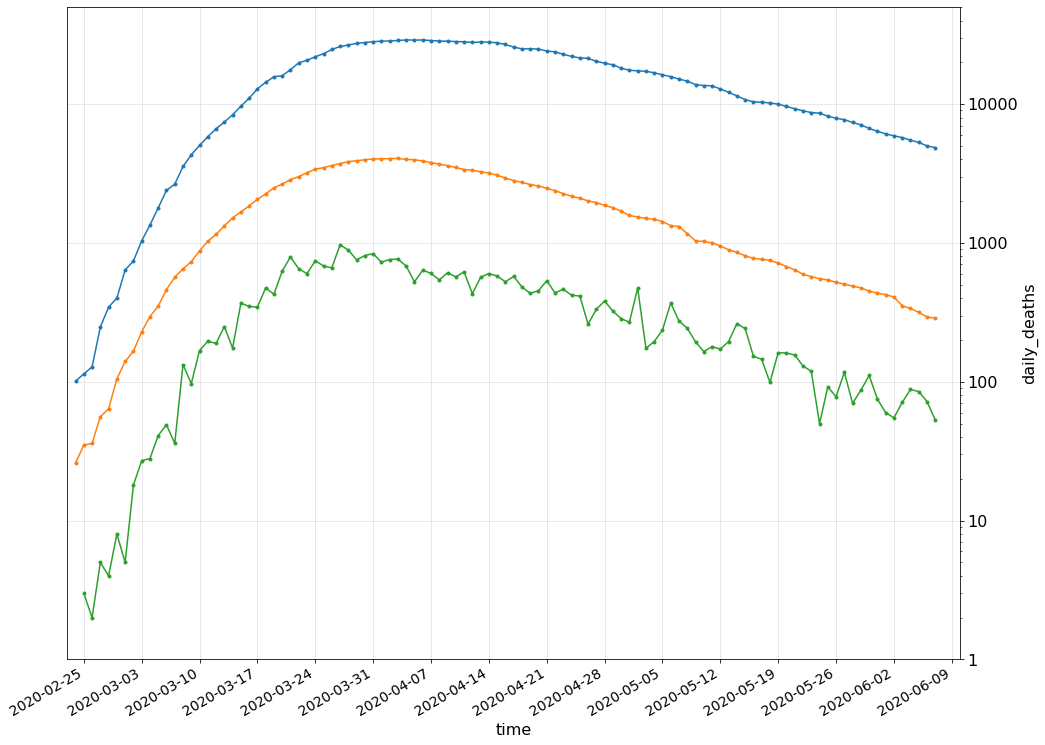

In [26]:
_, ax = covid19.plot.subplots(subplot_kw={'xlim': XLIM})
ax.set(yscale='log', ylim=(1, 50000)) 

for (kind, fits_kind), color in zip(fits.items(), PALETTE_ONE):
    label = LABEL[kind]
    covid19.plot.plot_data(ax, ds_italy[kind], label=label, color=color)

covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)
    
_ = ax.set_title(f'COVID-19 Italia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="")
_ = ax.legend()

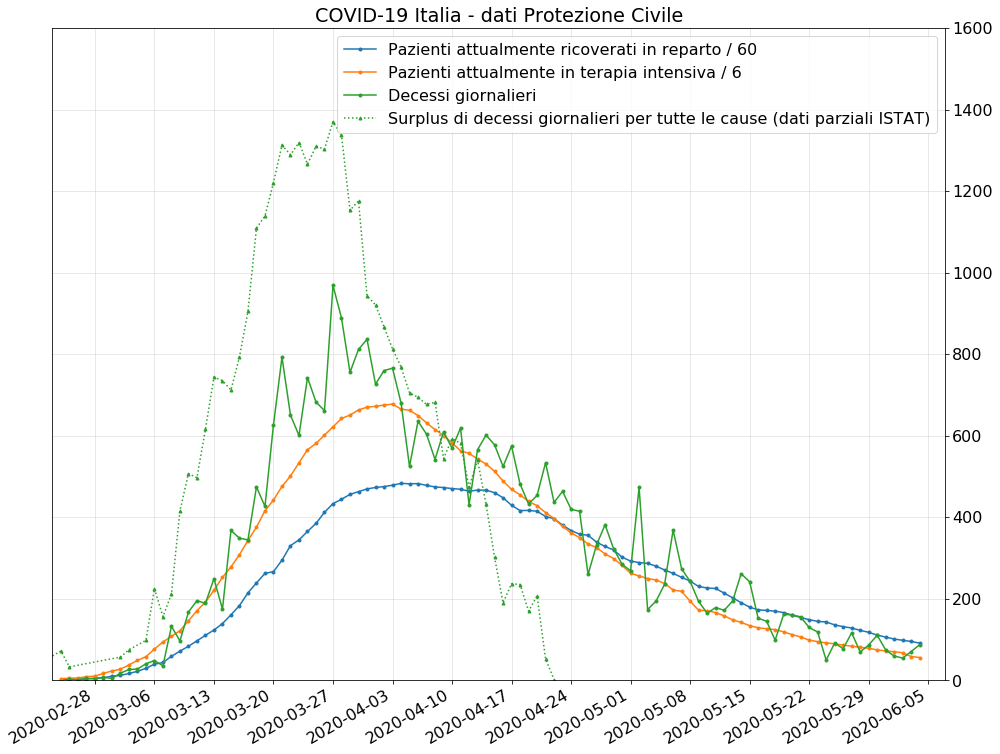

In [75]:
_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': XLIM, 'ylim': (0, 1600)})

for (kind, fits_kind), color in zip(fits.items(), PALETTE_ONE):
    label = LABEL[kind] + ('' if RATIO[kind] == 1 else f' / {RATIO[kind]}')
    covid19.plot.plot_data(ax, ds_italy[kind] / RATIO[kind], label=label, color=color)

covid19.plot.plot_data(ax, istat_italy, label='Surplus di decessi giornalieri per tutte le cause (dati parziali ISTAT)', color=color, marker='^', linestyle=':', date_interval=7)

_ = ax.set_title(f'COVID-19 Italia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="")
_ = ax.legend()
_ = ax.set(ylim=(0, None))

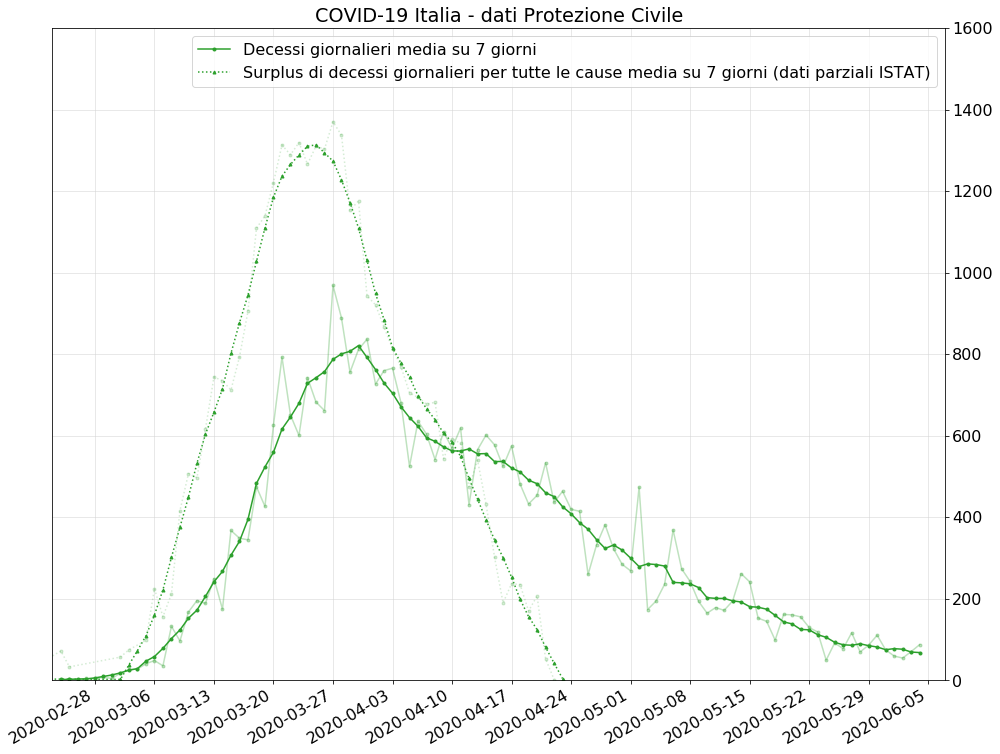

In [77]:
_, ax = covid19.plot.subplots(1, subplot_kw={'xlim': XLIM, 'ylim': (0, 1600)})

for (kind, fits_kind), color in zip(fits.items(), PALETTE_ONE):
    label = LABEL[kind] + ('' if RATIO[kind] == 1 else f' / {RATIO[kind]}')
    if kind == 'daily_deaths':
        covid19.plot.plot_data(ax, ds_italy[kind] / RATIO[kind], color=color, alpha=0.3)
        covid19.plot.plot_data(ax, ds_italy[kind].rolling({'time': 7}, center=True, min_periods=1).mean() / RATIO[kind], label=label + ' media su 7 giorni', color=color)
    else:
        pass
        #covid19.plot.plot_data(ax, ds_italy[kind] / RATIO[kind], label=label, color=color)

covid19.plot.plot_data(ax, istat_italy, color=color, linestyle=':', alpha=0.2)
covid19.plot.plot_data(ax, istat_italy.rolling({'time': 7}, center=True, min_periods=1).mean(), color=color, label='Surplus di decessi giornalieri per tutte le cause media su 7 giorni (dati parziali ISTAT)', marker='^', linestyle=':', date_interval=7)

_ = ax.set_title(f'COVID-19 Italia - dati Protezione Civile')
_ = ax.set(xlabel="", ylabel="")
_ = ax.legend()
_ = ax.set(ylim=(0, None))

In [51]:
REGIONS_FIT_PARAMS = {
    'Lombardia': {
        'current_severe': [None, '2020-03-07', '2020-03-08', '2020-03-18'],
        'current_critical': 0,
        'daily_deaths': 4,
    },
    'Emilia-Romagna': {
        'current_severe': [None, '2020-03-06', '2020-03-21'],
        'current_critical': 0,
        'daily_deaths': [None, '2020-03-23'],
    },
    'Piemonte': {
        'current_severe': [None, '2020-03-20', '2020-03-21'],
        'current_critical': 0,
        'daily_deaths': 4,
    },
    'Veneto': {
        'current_severe': [None, '2020-03-13', '2020-03-14', '2020-03-24'],
        'current_critical': 0,
        'daily_deaths': 4,
    },
    'Marche': {
        'current_severe': [None, '2020-03-16', '2020-03-21'],
        'current_critical': 0,
        'daily_deaths': 4,
    },
    'Liguria': {
        'current_severe': [None, '2020-03-21'],
        'current_critical': 0,
        'daily_deaths': 4,
    },
    'Toscana': {
        'current_severe': [None, '2020-03-19'],
        'current_critical': 0,
        'daily_deaths': 4,
    },
    'Lazio': {
        'current_severe': [None, '2020-03-21', '2020-03-28'],
        'current_critical': 0,
        'daily_deaths': 4,
    },
    'P.A. Trento': {
        'current_severe': [None, '2020-03-21'],
        'current_critical': 0,
        'daily_deaths': 4,
    },
    'Campania': {
        'current_severe': [None, '2020-03-26'],
        'current_critical': 0,
        'daily_deaths': 4,
    },
    'Puglia': {
        'current_severe': [None, '2020-03-16', '2020-03-26'],
        'current_critical': 0,
        'daily_deaths': 4,
    },
    'Sicilia': {
        'current_severe': [None, '2020-03-21', None],
        'current_critical': 0,
        'daily_deaths': 4,
    },
    'Abruzzo': {
        'current_severe': [None, '2020-03-21', None],
        'current_critical': 0,
        'daily_deaths': 4,
    },
    'Friuli Venezia Giulia': {
        'current_severe': [None, '2020-03-16', '2020-03-24', None],
        'current_critical': 0,
        'daily_deaths': ['2020-03-20', '2020-03-31', None],
    },
    'P.A. Bolzano': {
        'current_severe': [None, '2020-03-21'],
        'current_critical': 0,
        'daily_deaths': 4,
    },
    'Umbria': {
        'current_severe': [None, '2020-03-21'],
        'current_critical': 0,
        'daily_deaths': 4,
    },
    'Calabria': {
        'current_severe': [None, '2020-03-21'],
        'current_critical': 0,
        'daily_deaths': 4,
    },
    'Sardegna': {
        'current_severe': [None, '2020-03-21'],
        'current_critical': 0,
        'daily_deaths': 4,
    },
    'Valle d\'Aosta': {
        'current_severe': [None, '2020-03-21'],
        'current_critical': 0,
        'daily_deaths': 4,
    },
    'Basilicata': {
        'current_severe': [None, '2020-03-21'],
        'current_critical': 0,
        'daily_deaths': 4,
    },
    'Molise': {
        'current_severe': [None, '2020-03-21'],
        'current_critical': 0,
        'daily_deaths': 4,
    },
}

In [52]:
STOP_FIT = '2020-04-03'

region_fits = {}
for region, params in REGIONS_FIT_PARAMS.items():
    region_fits[region] = {}
    for kind, breaks in params.items():
        if isinstance(breaks, int):
            breaks = [np.datetime64(b) + breaks * DAY if b is not None else b for b in params['current_severe']]
        region_fits[region][kind] = covid19.fit.fit_exponential_segments(ds_italy_regions.sel(location=region)[kind], breaks=breaks)

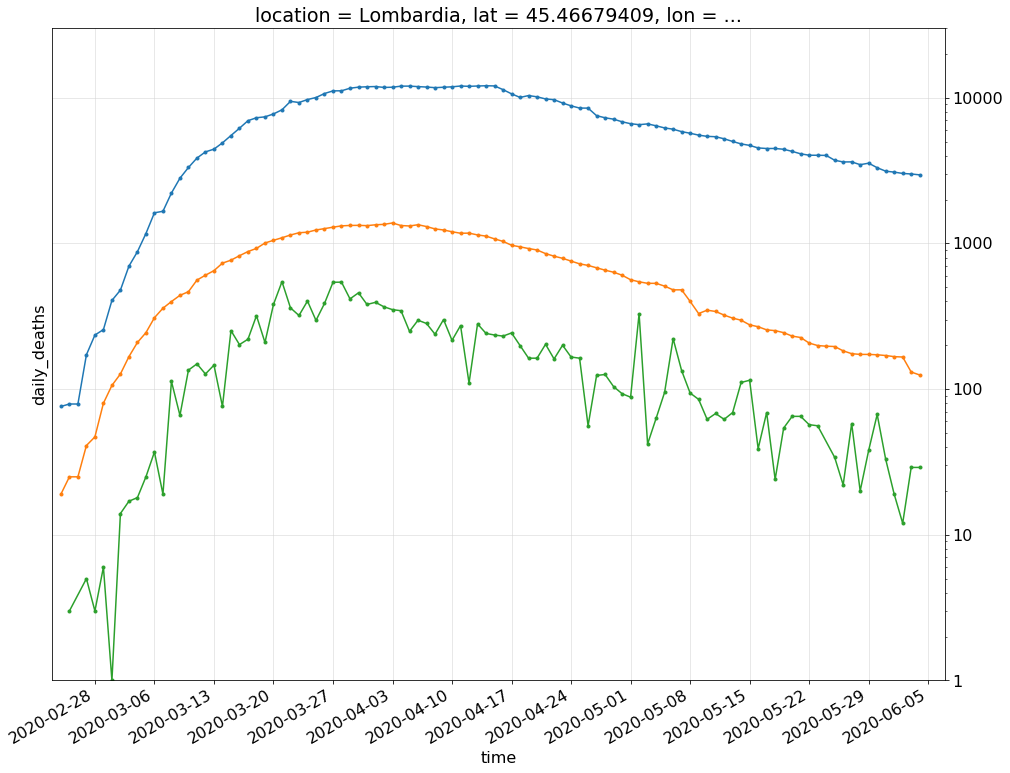

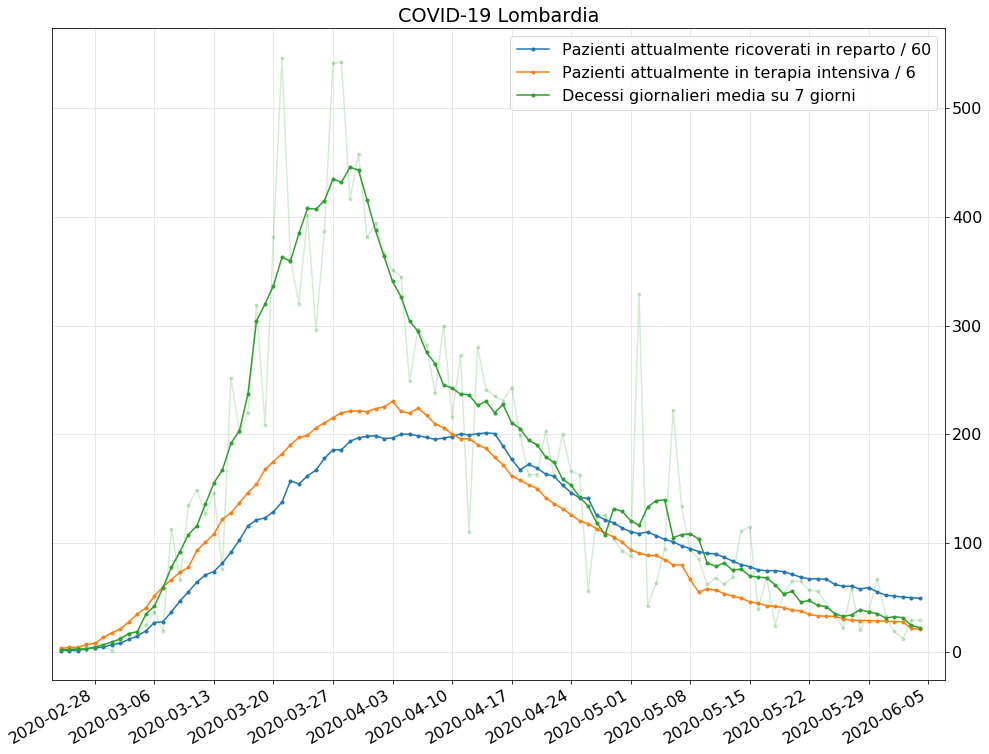

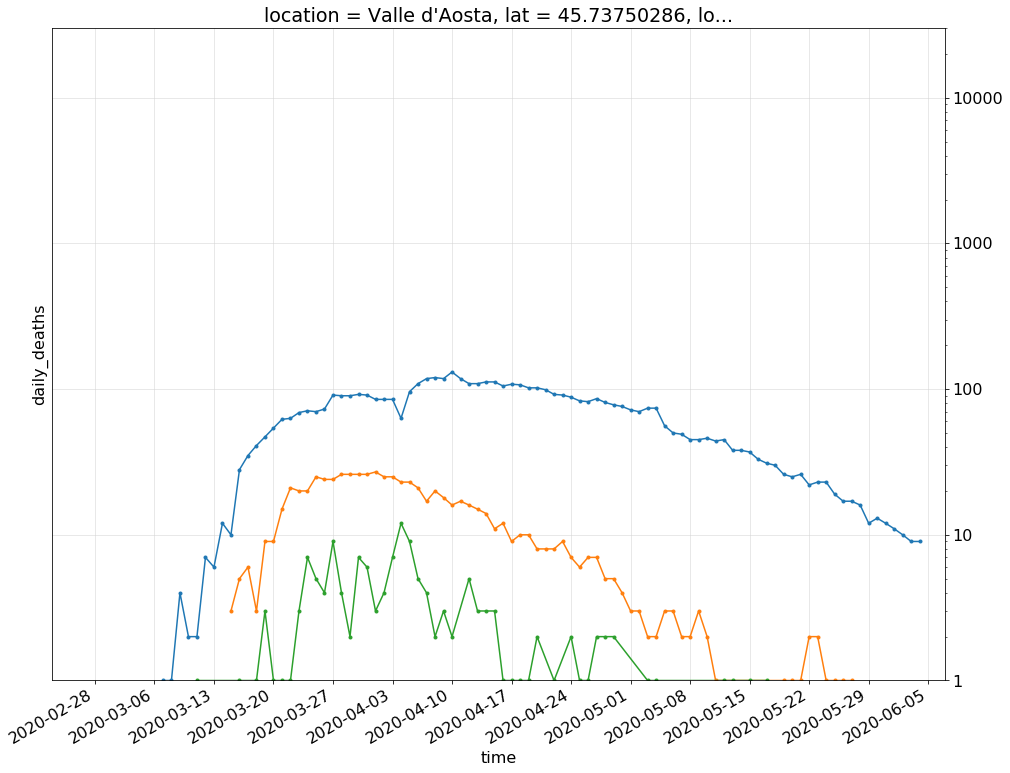

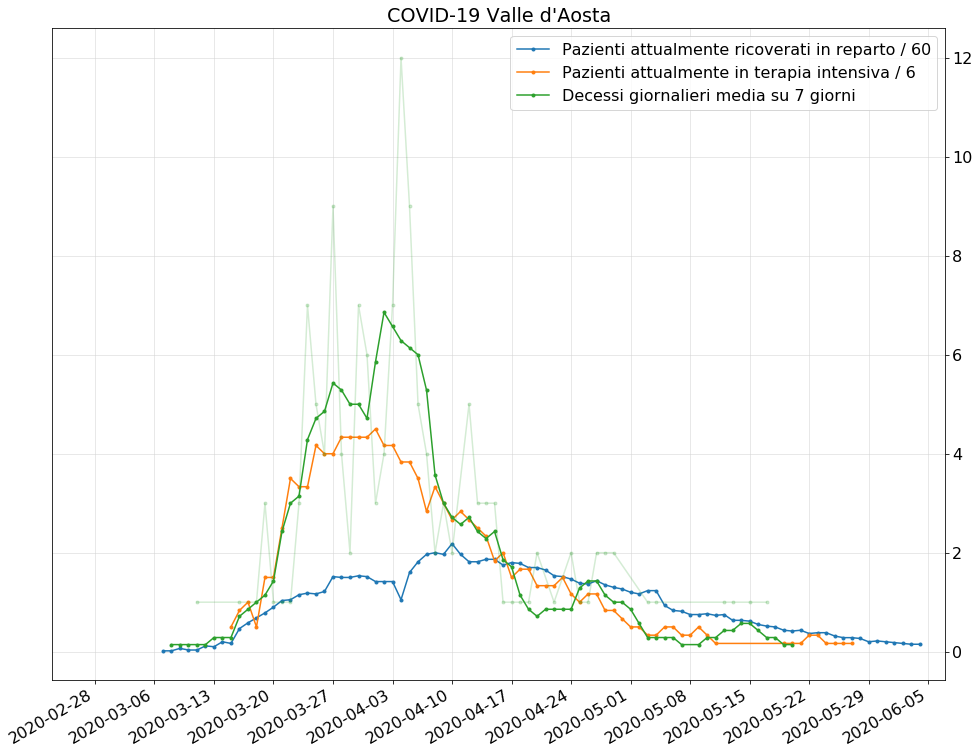

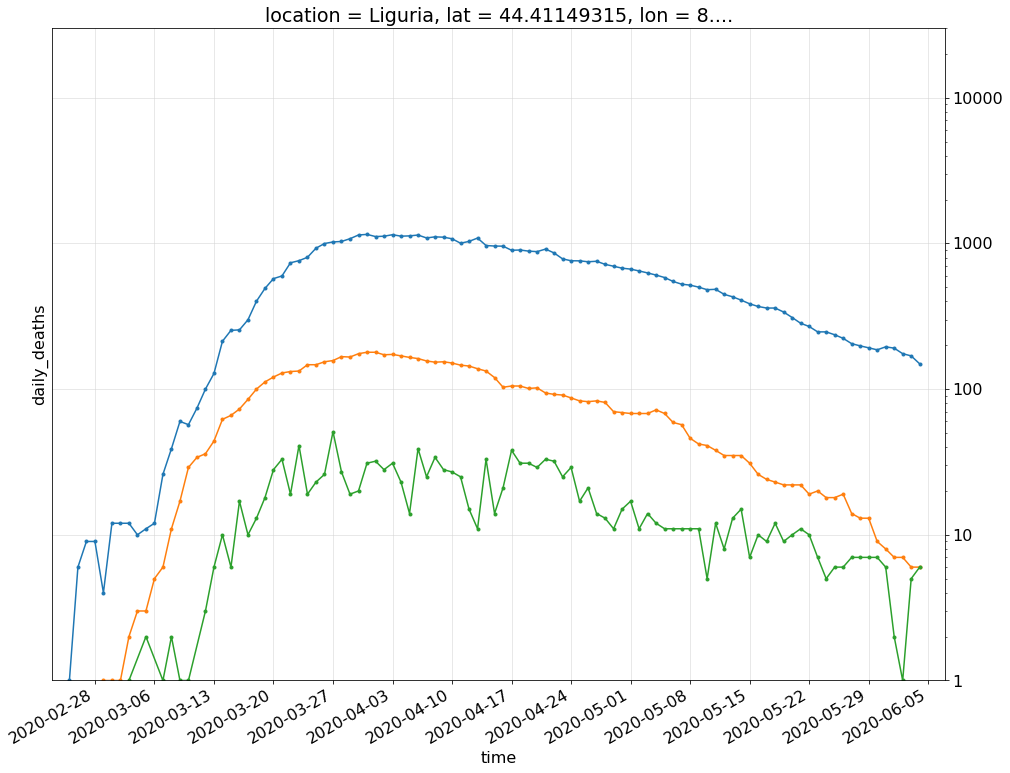

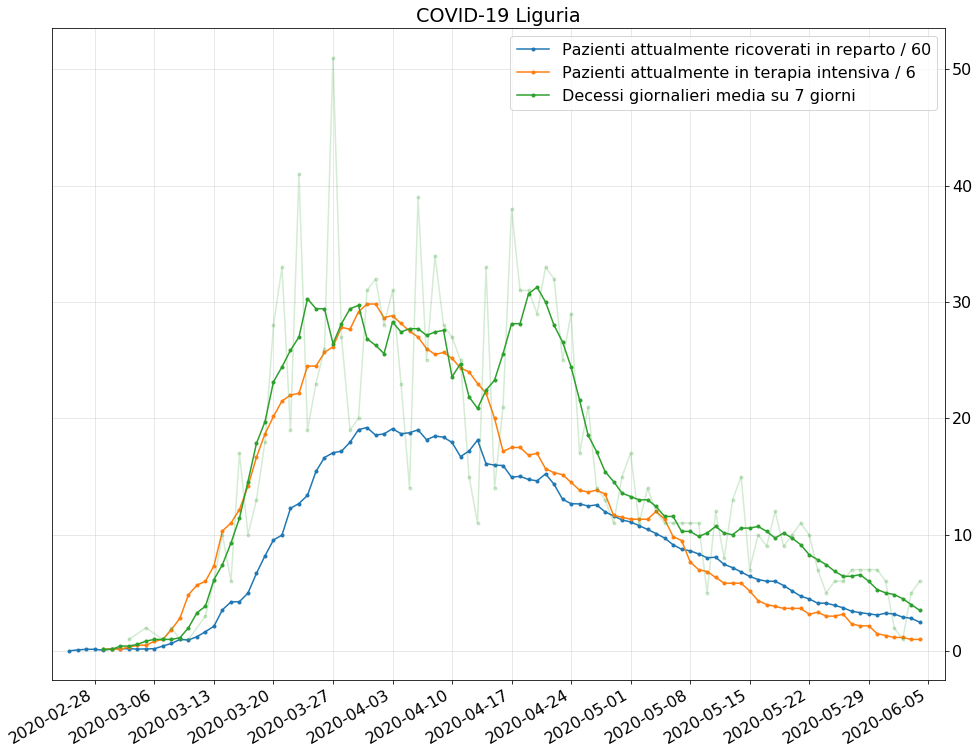

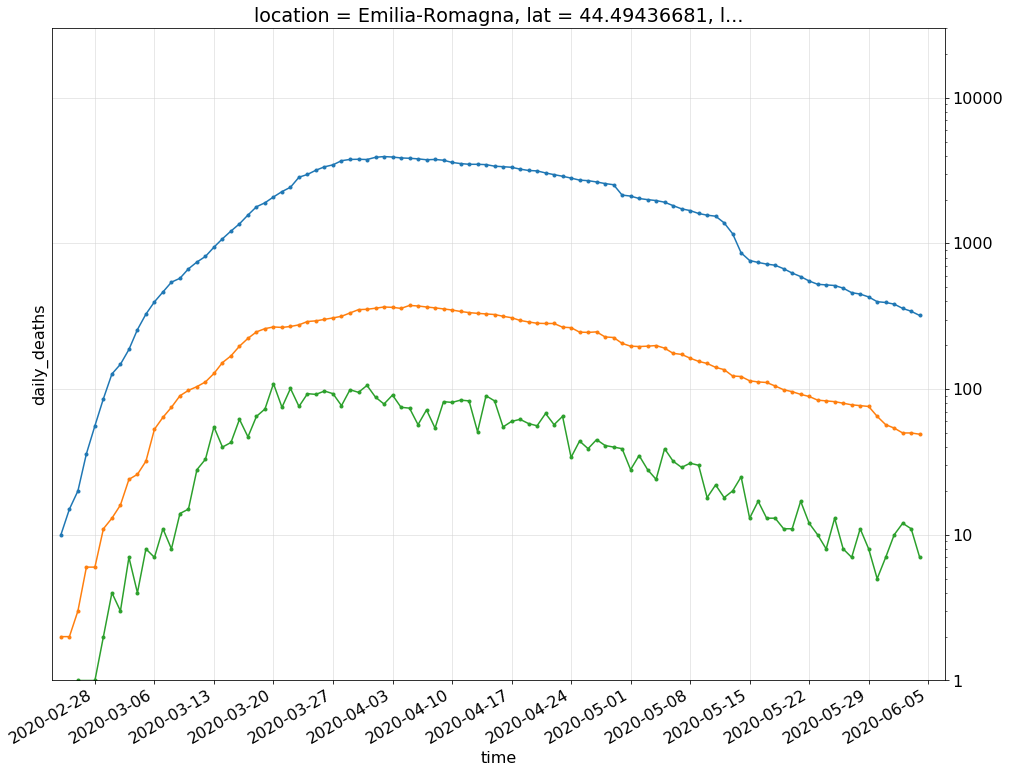

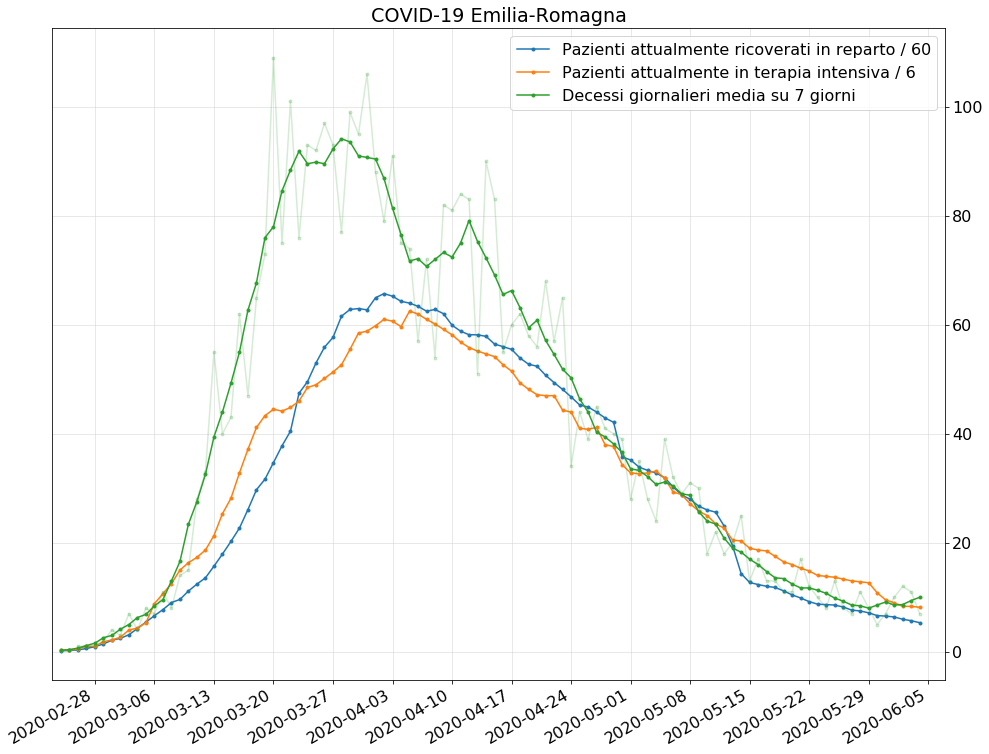

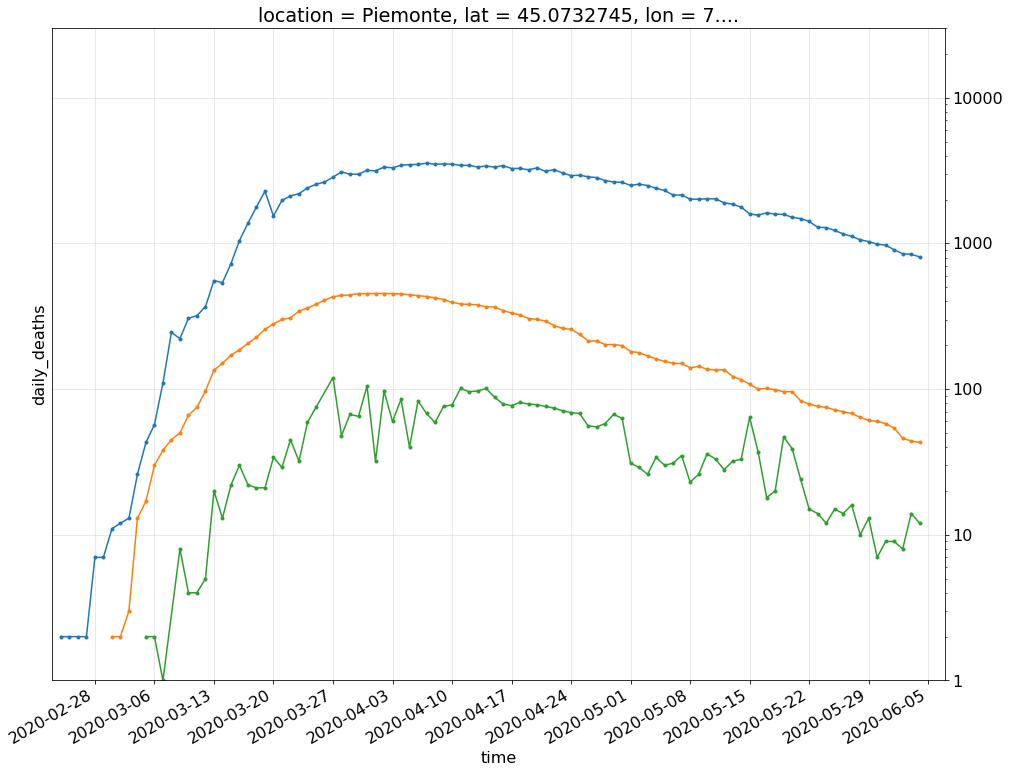

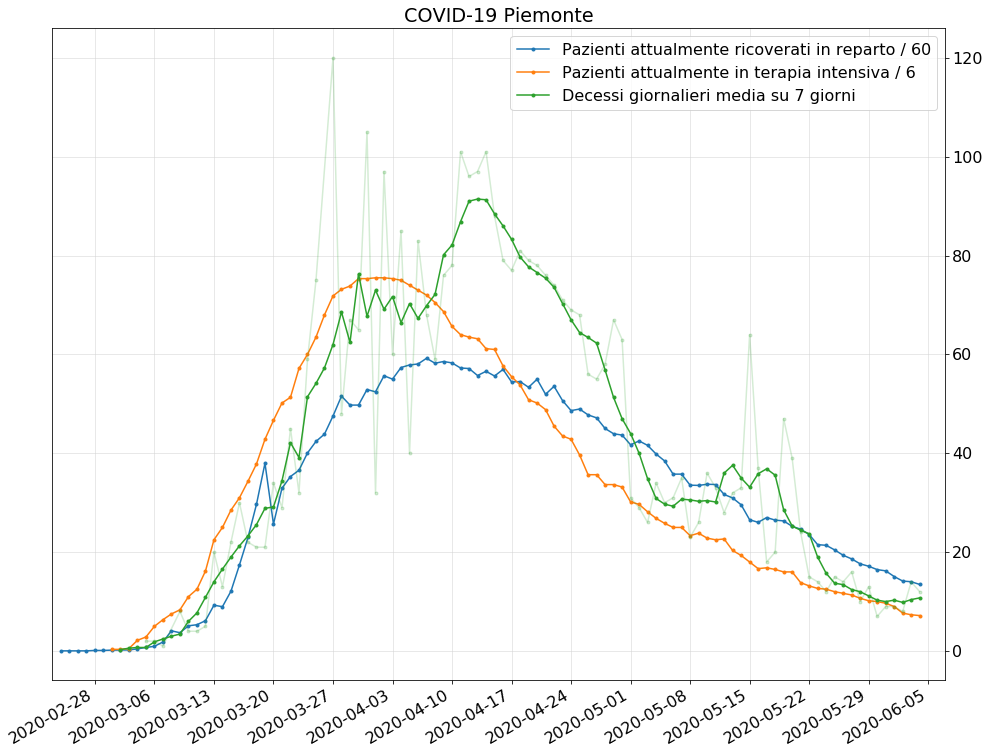

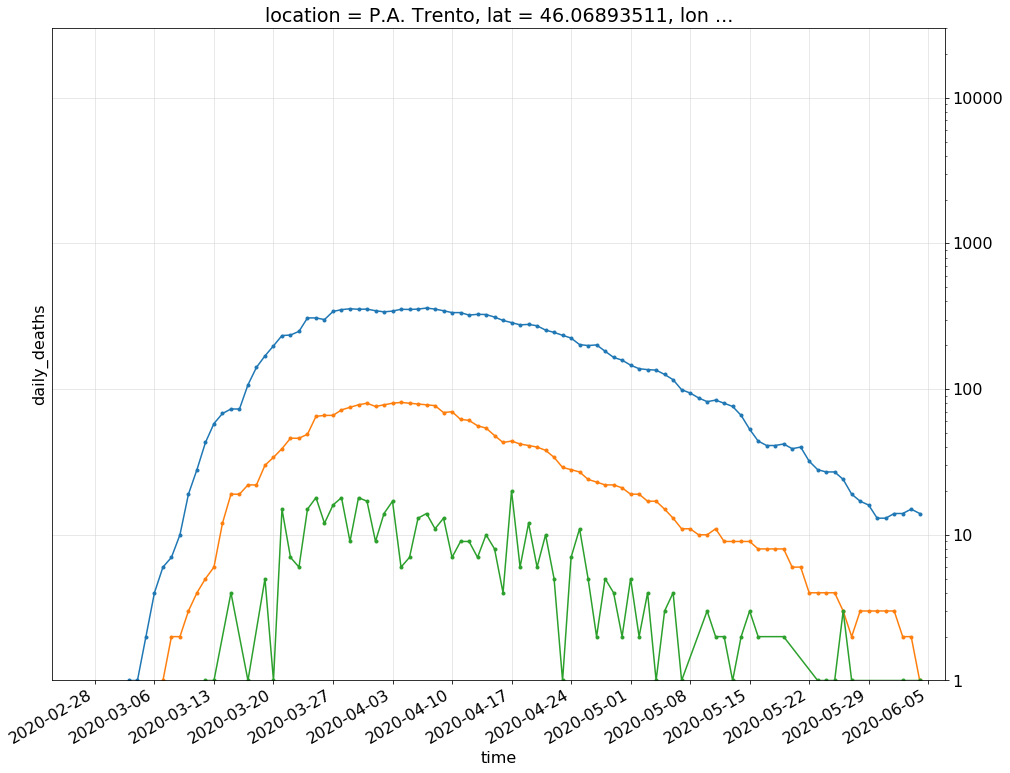

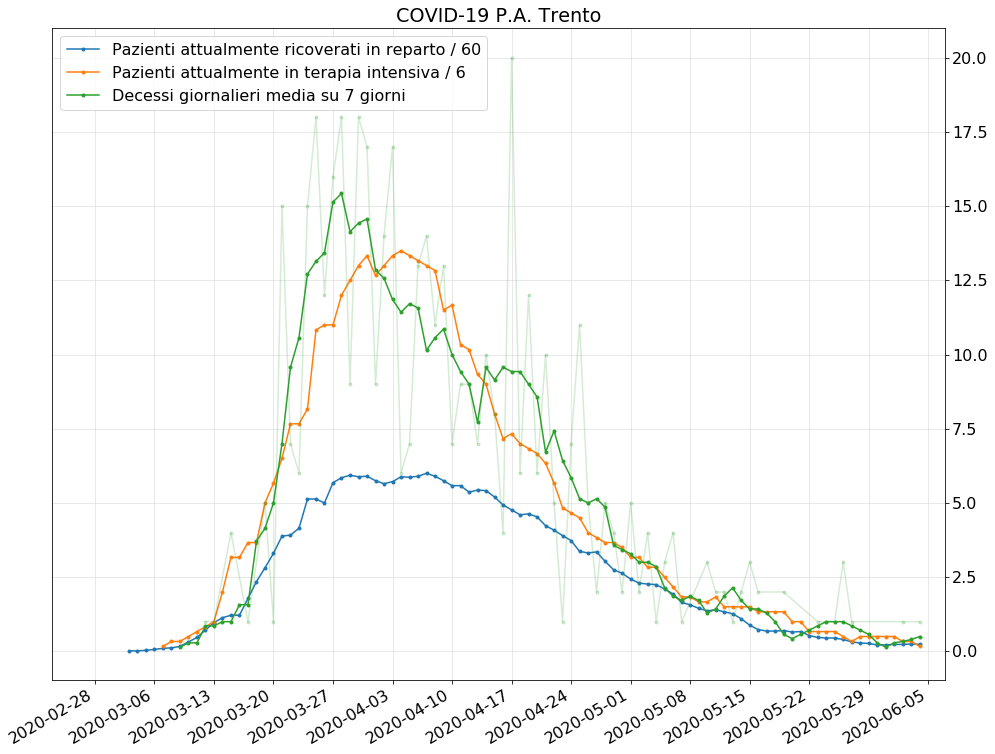

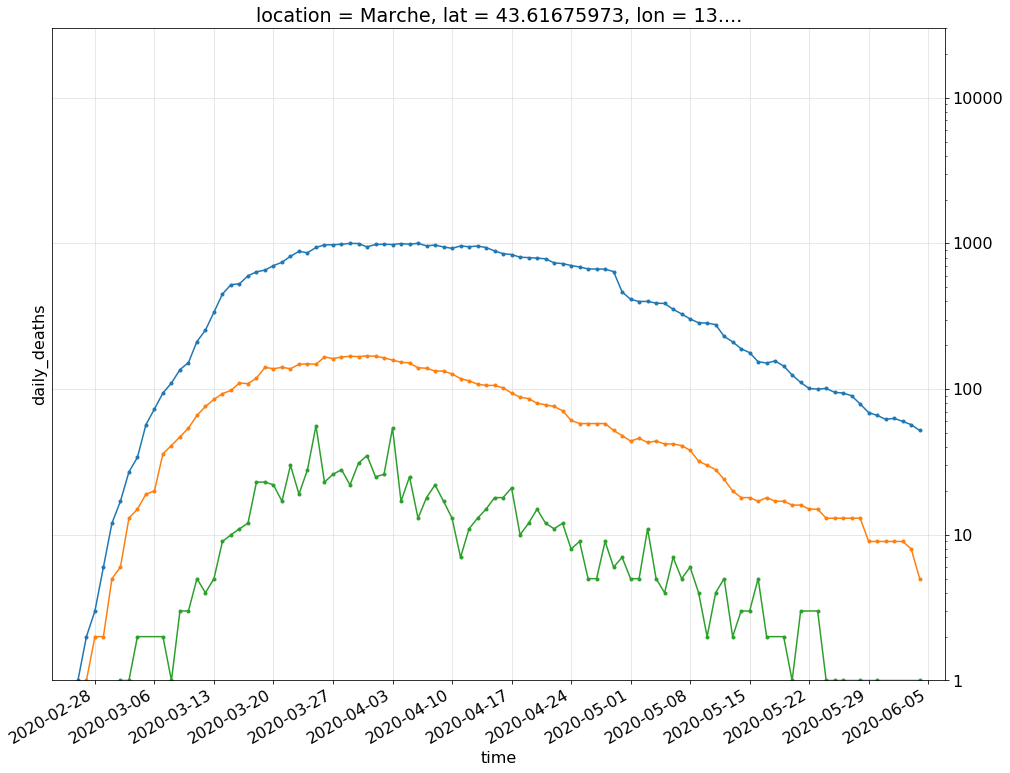

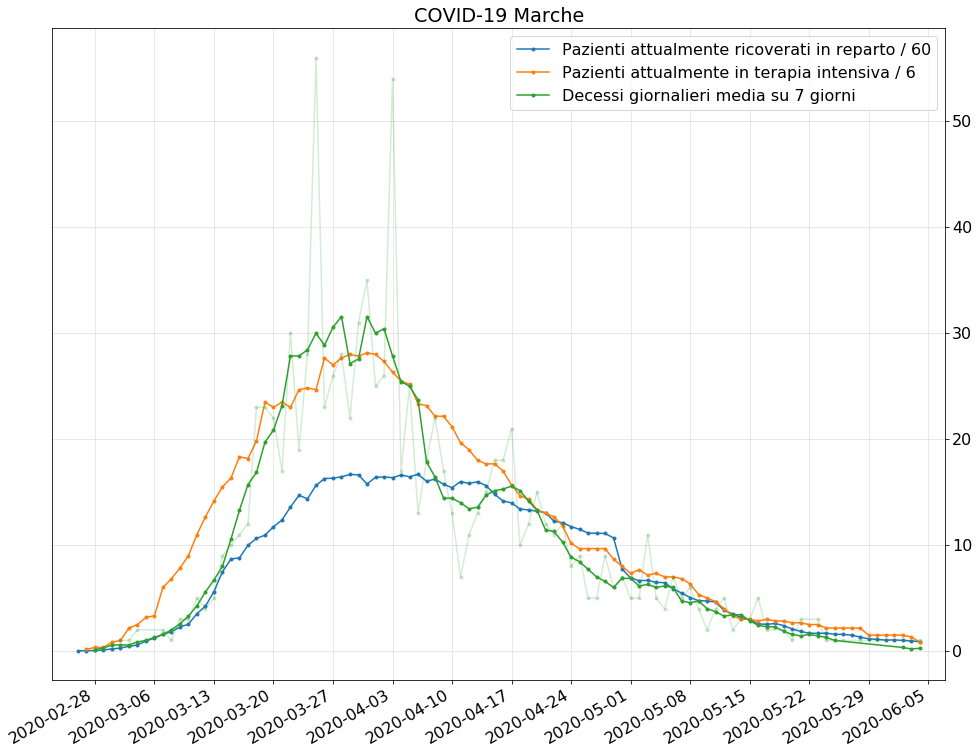

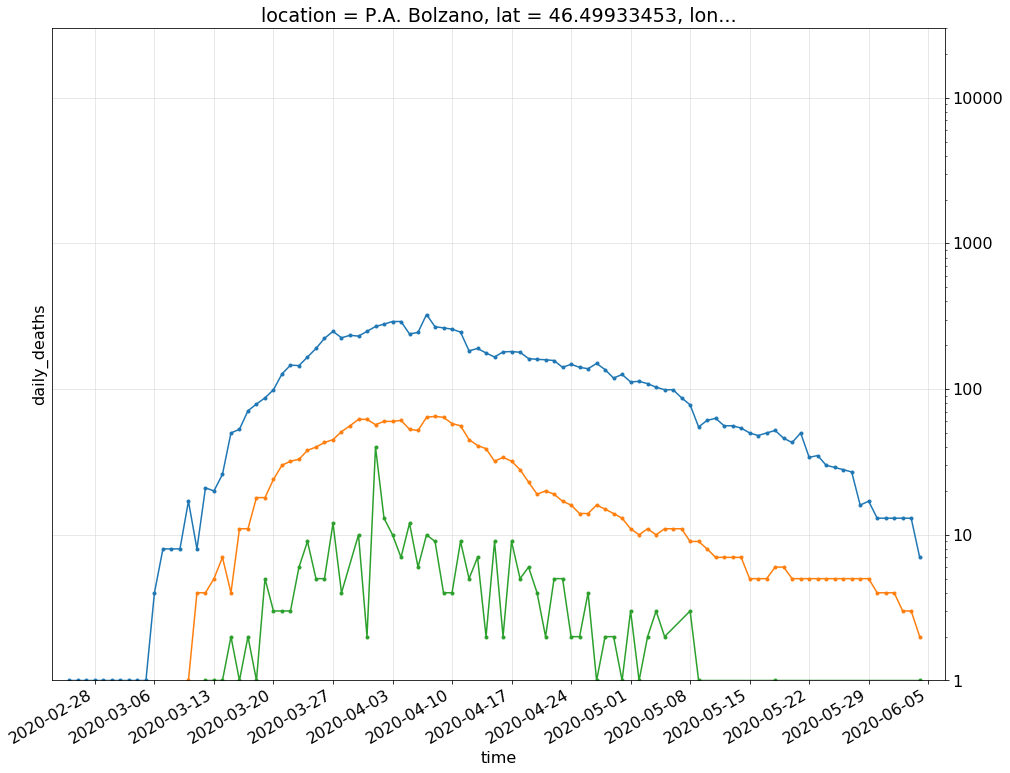

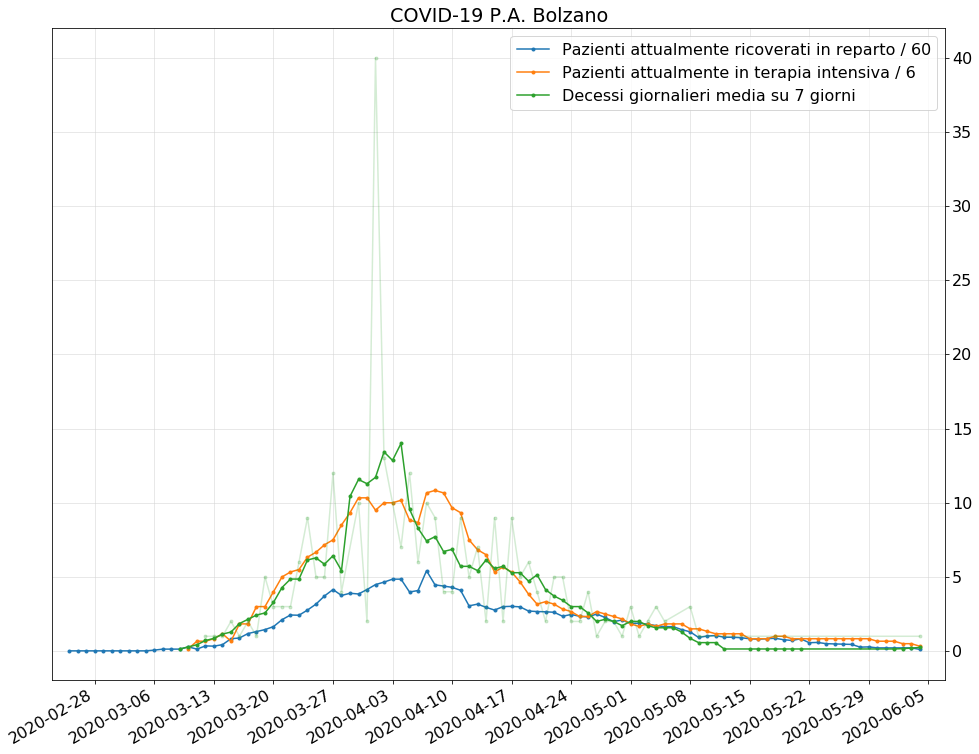

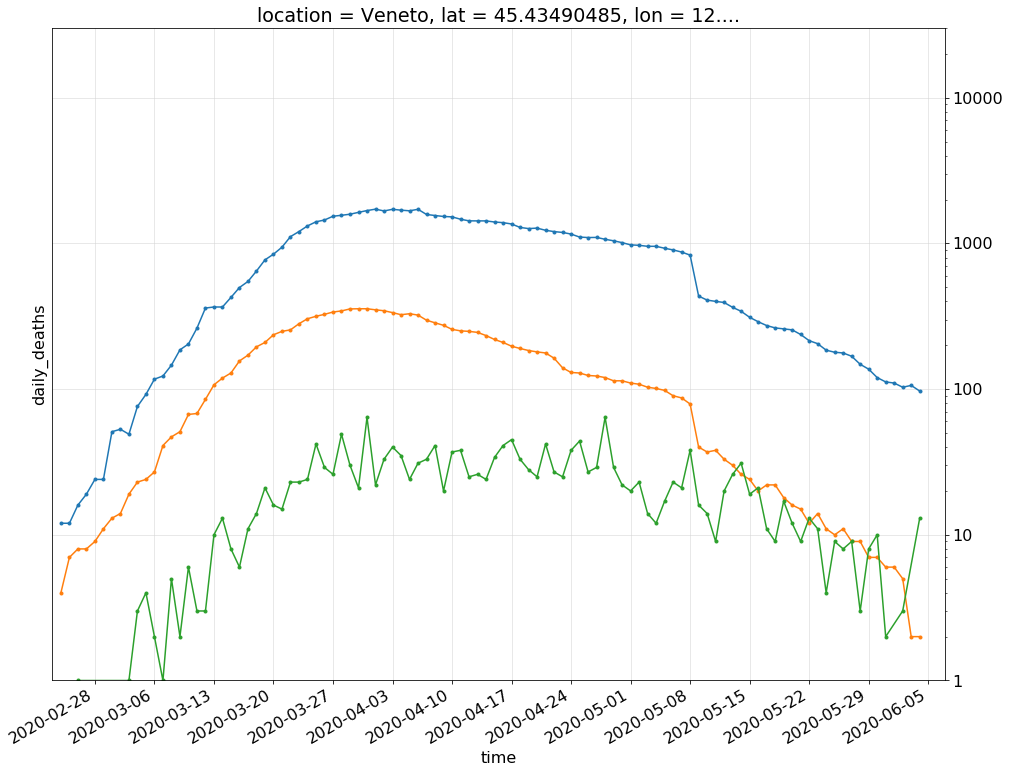

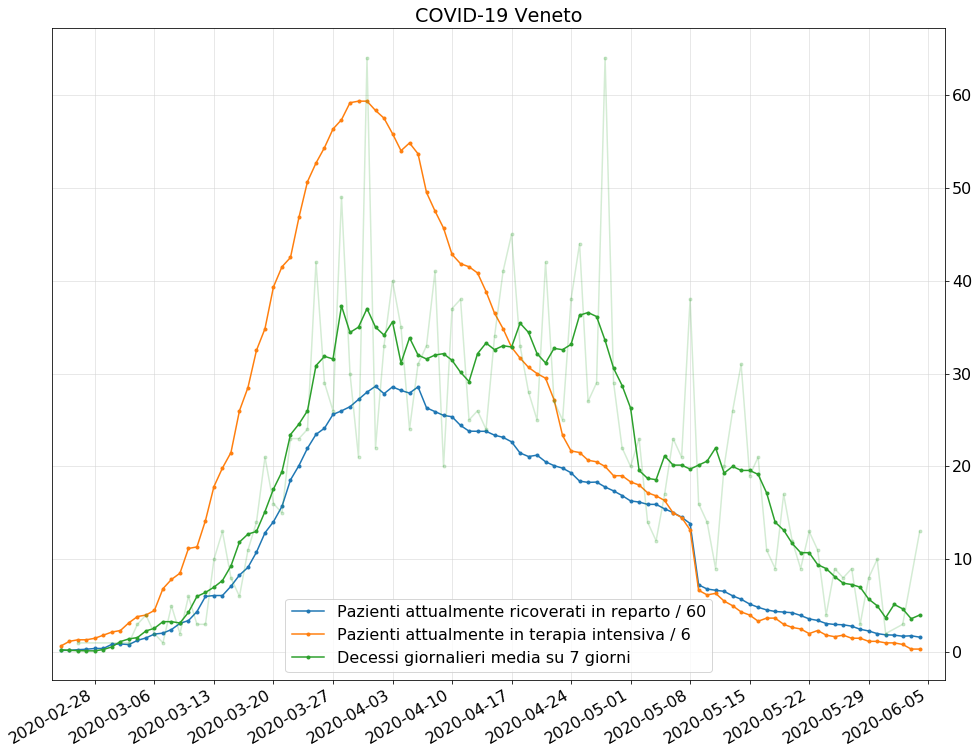

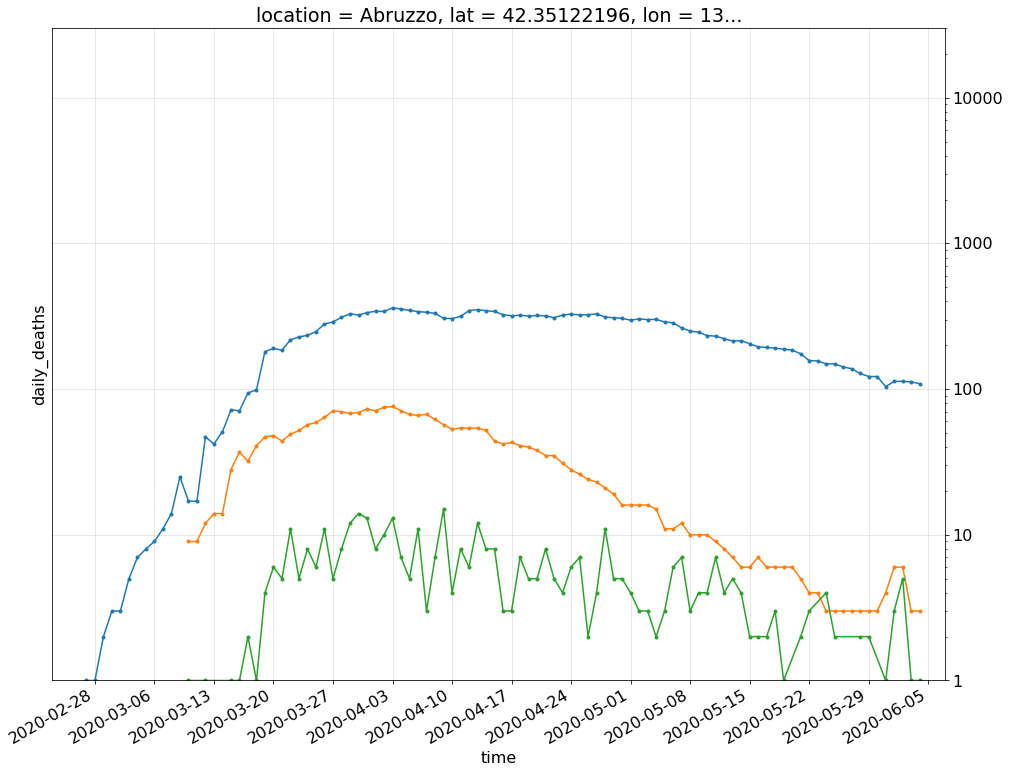

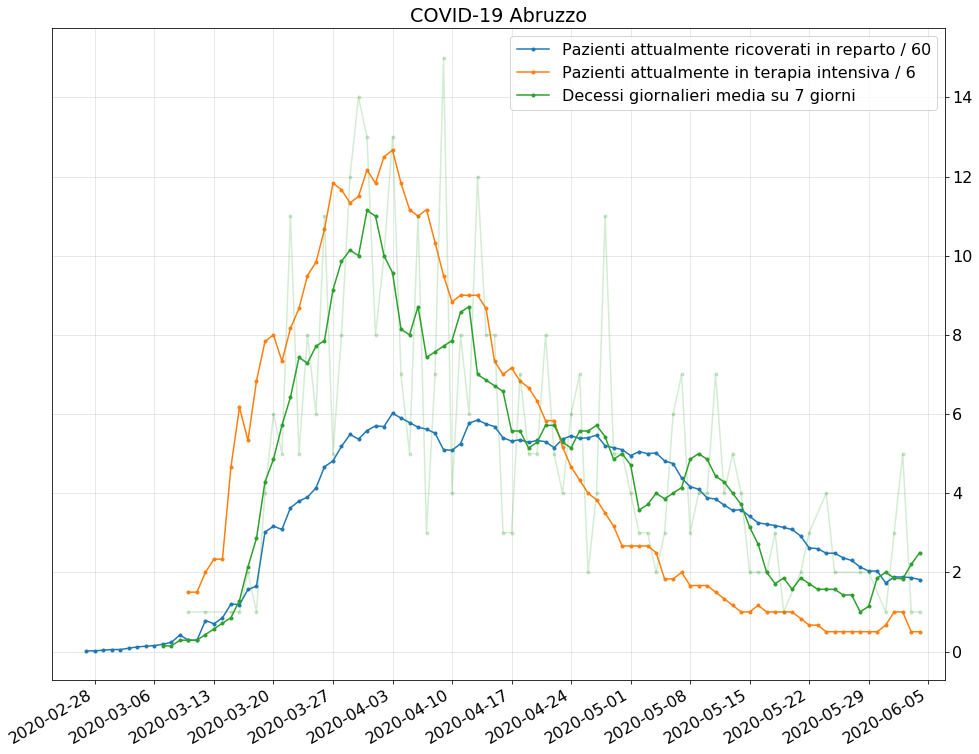

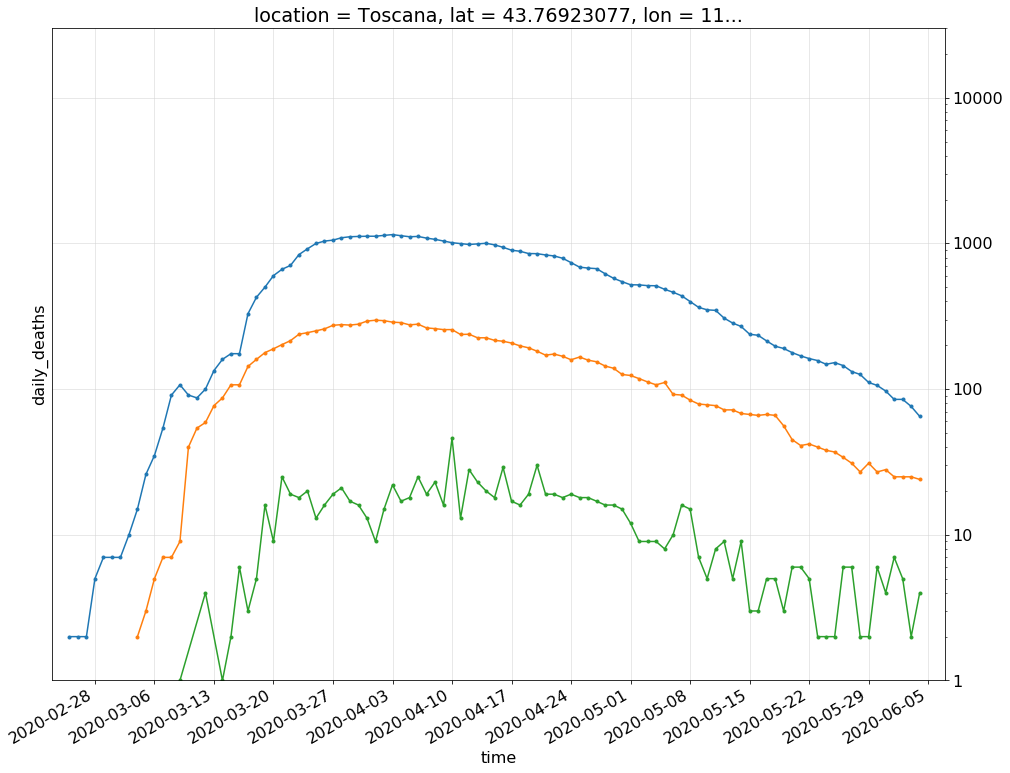

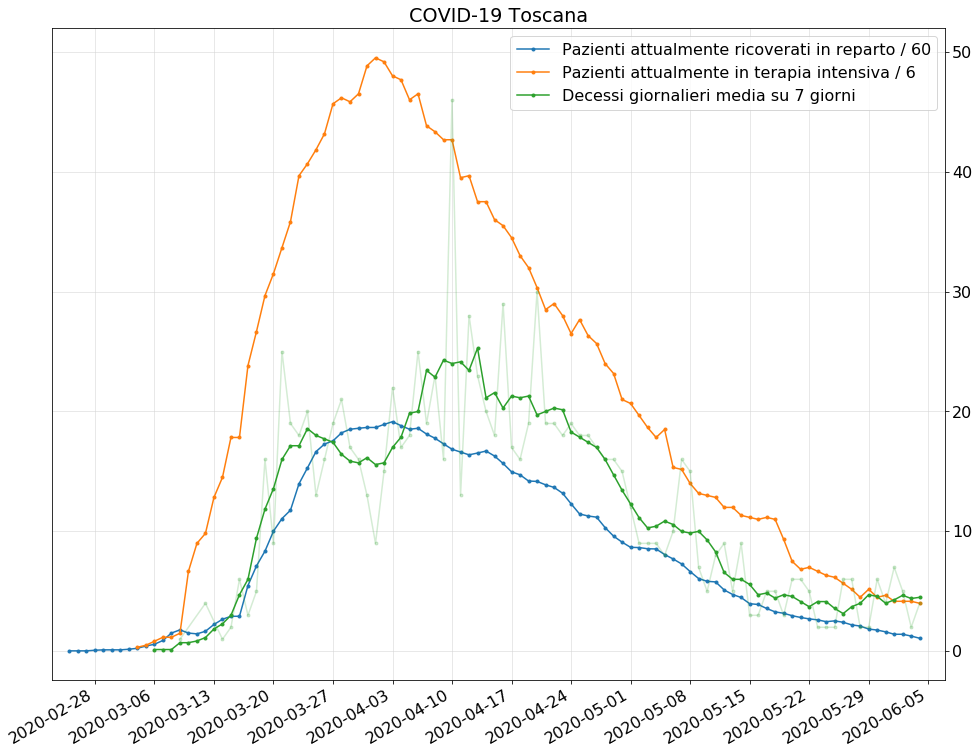

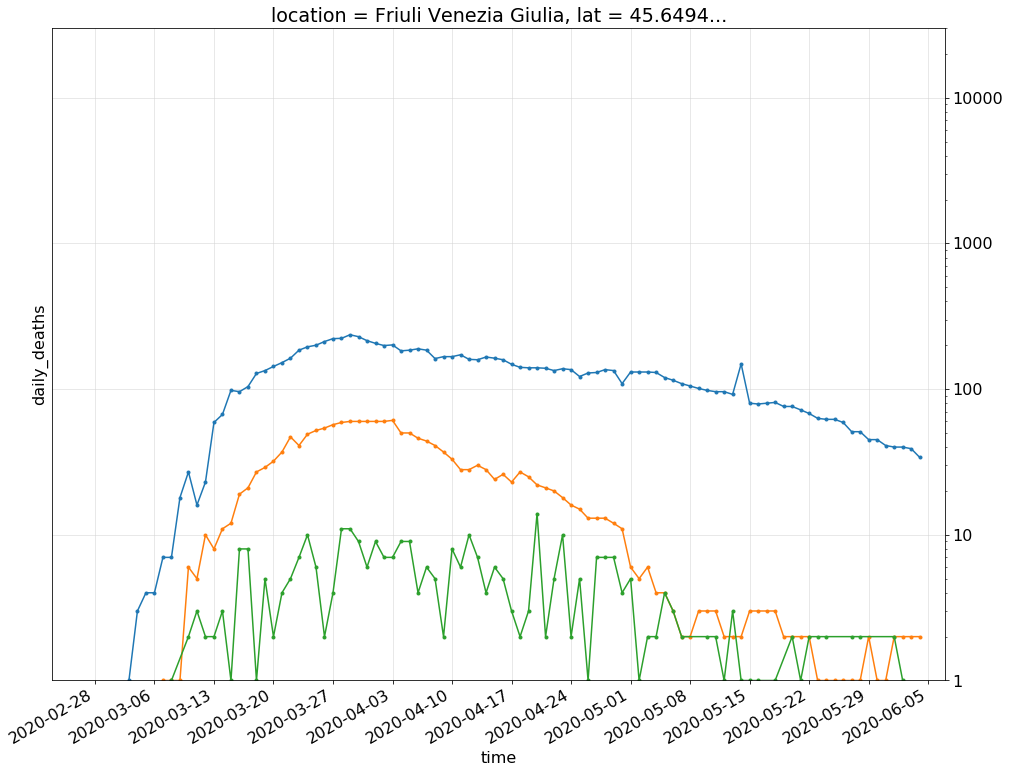

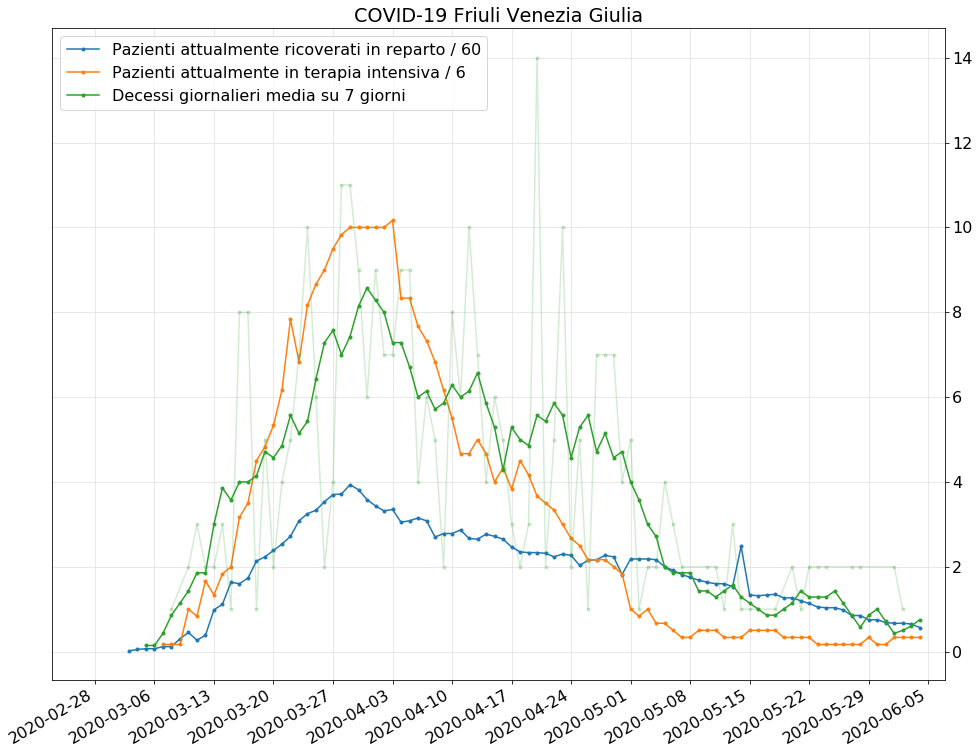

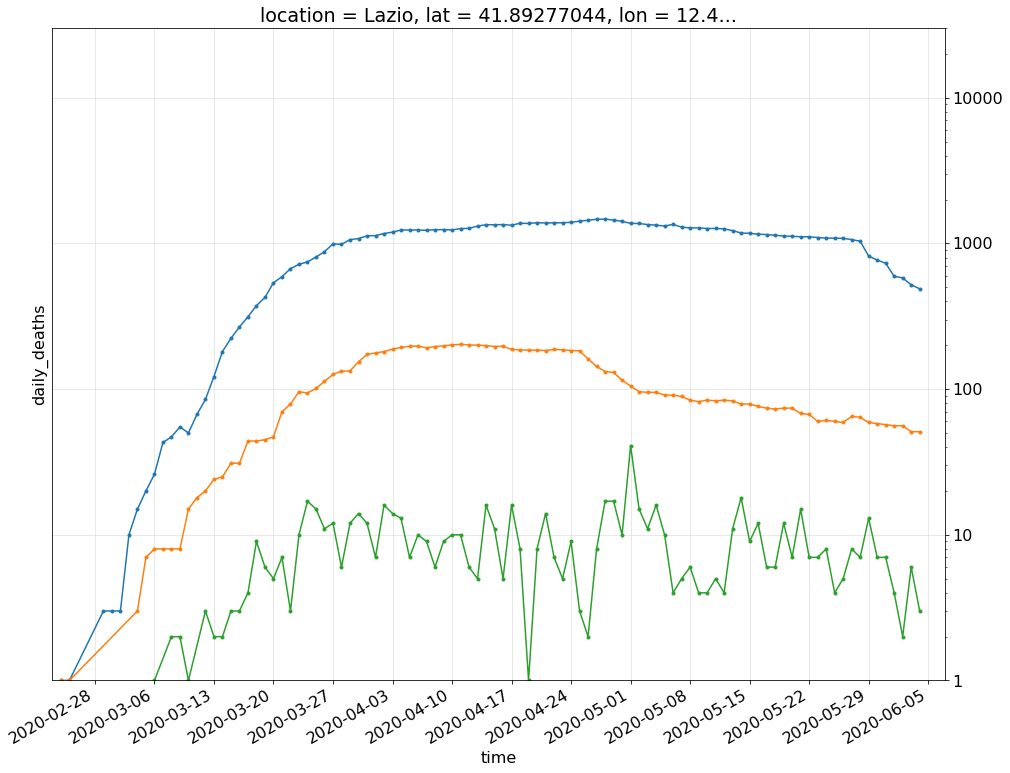

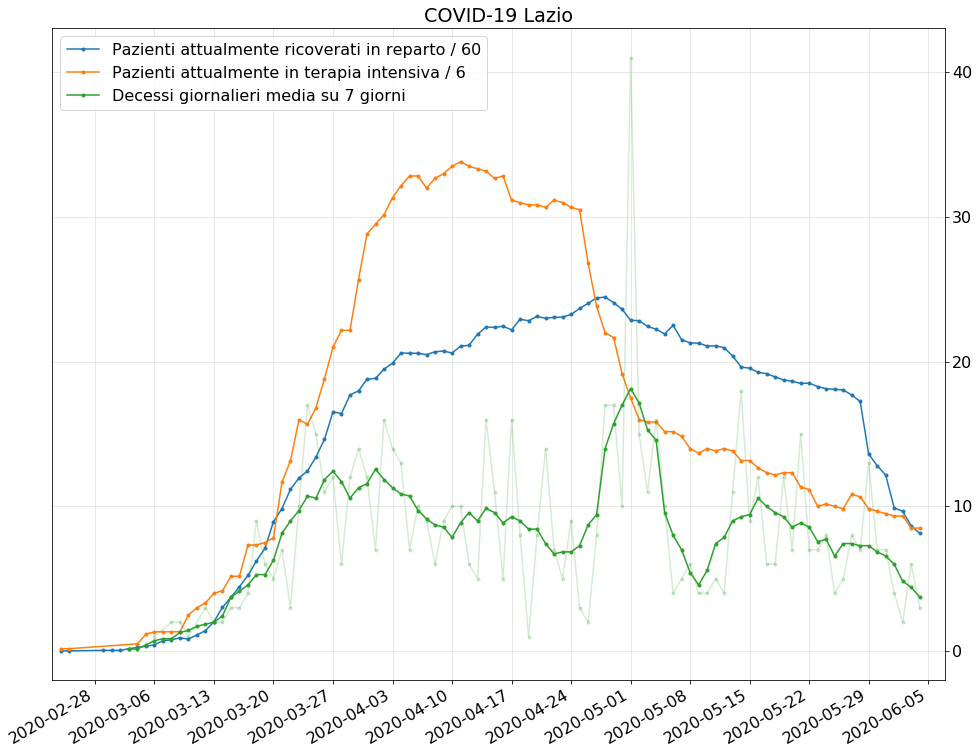

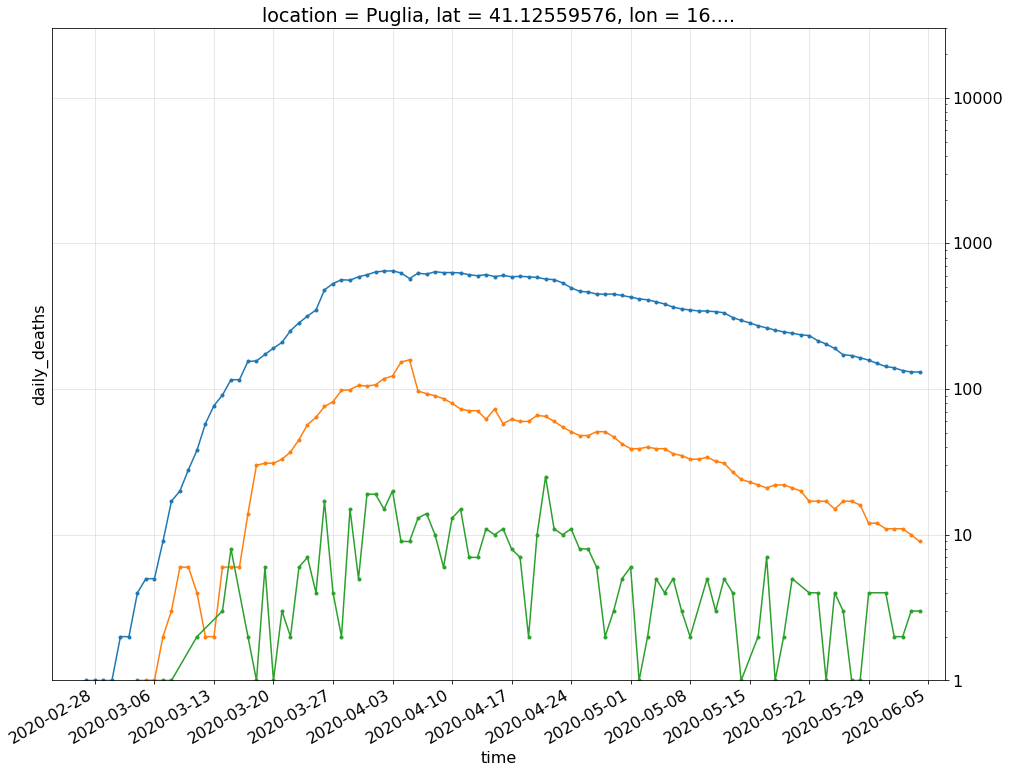

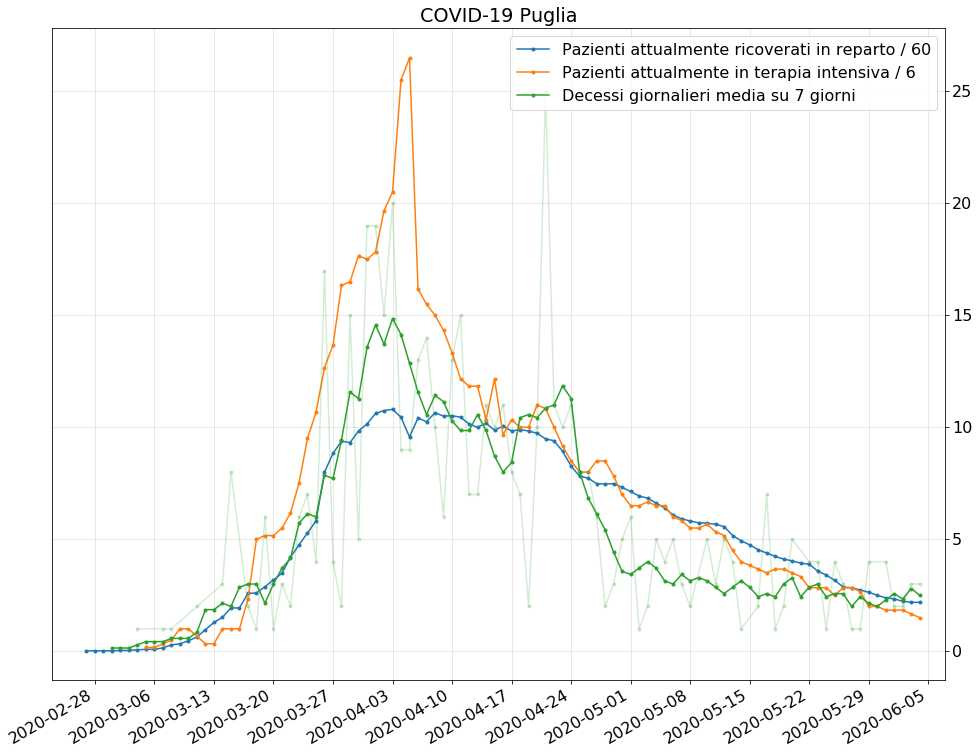

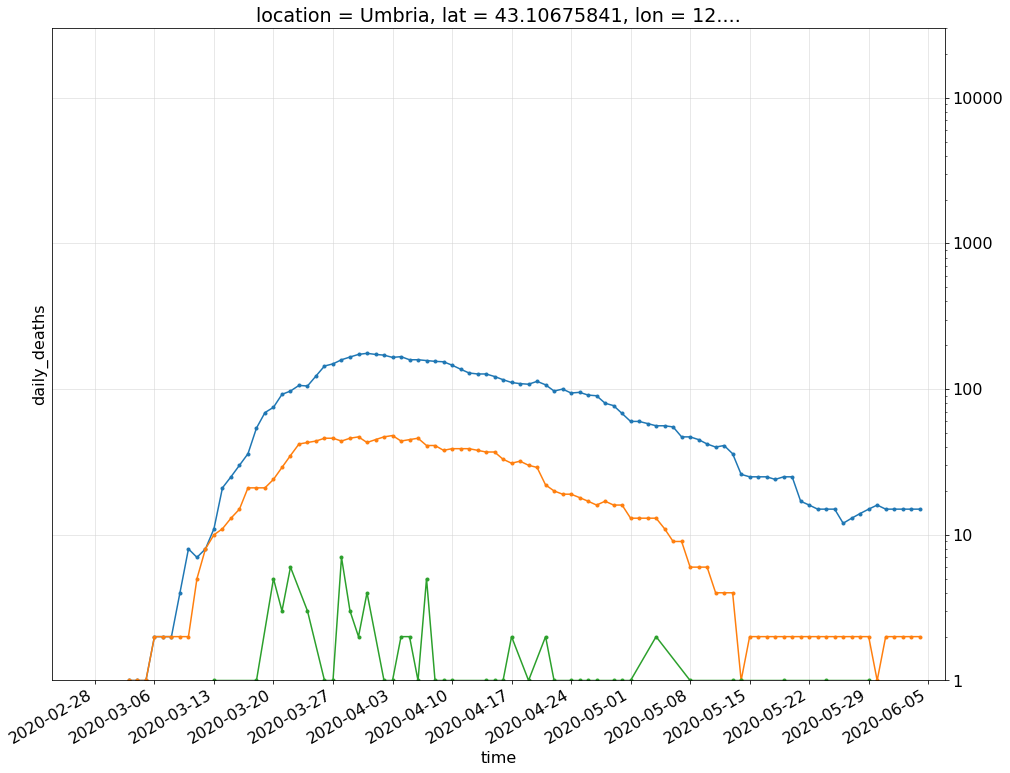

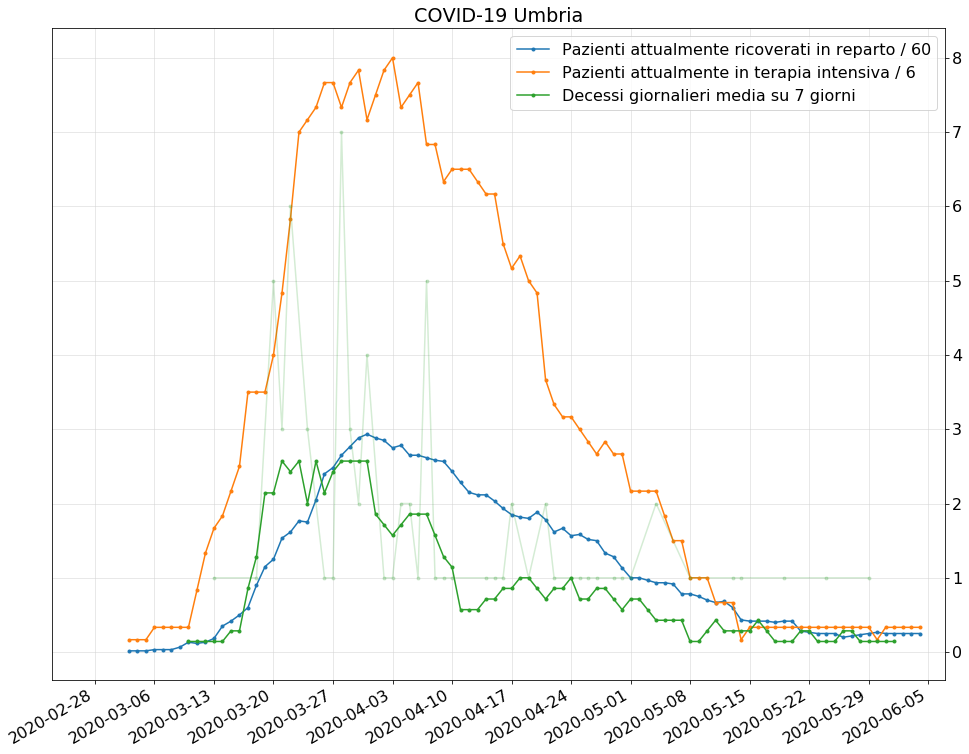

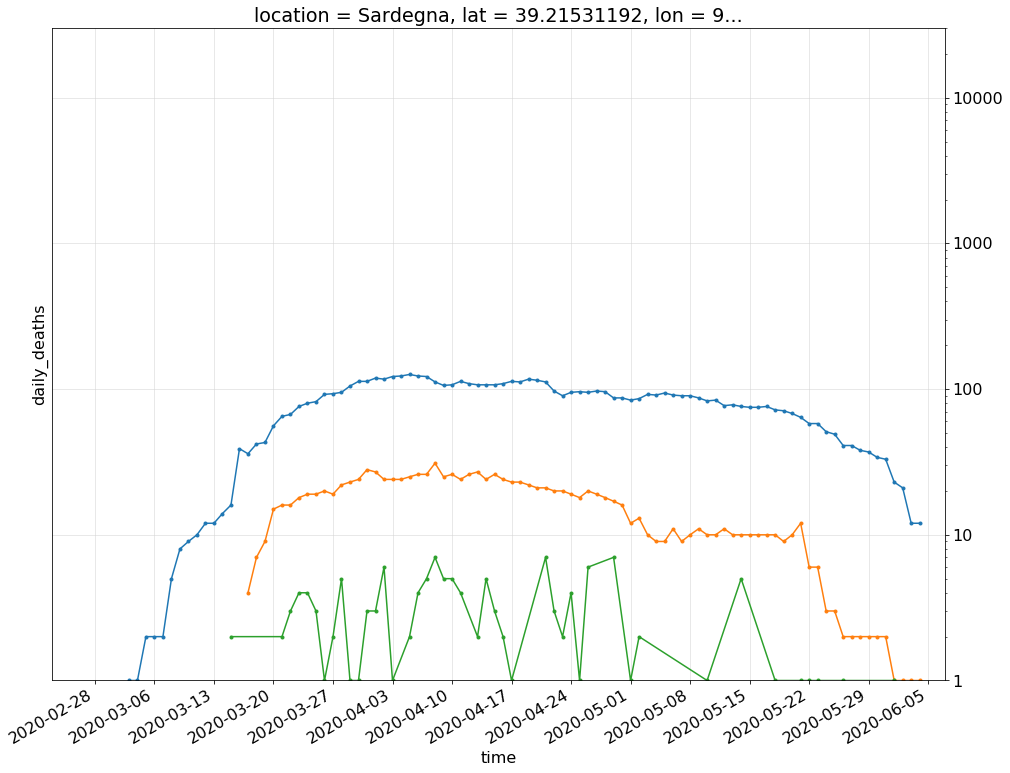

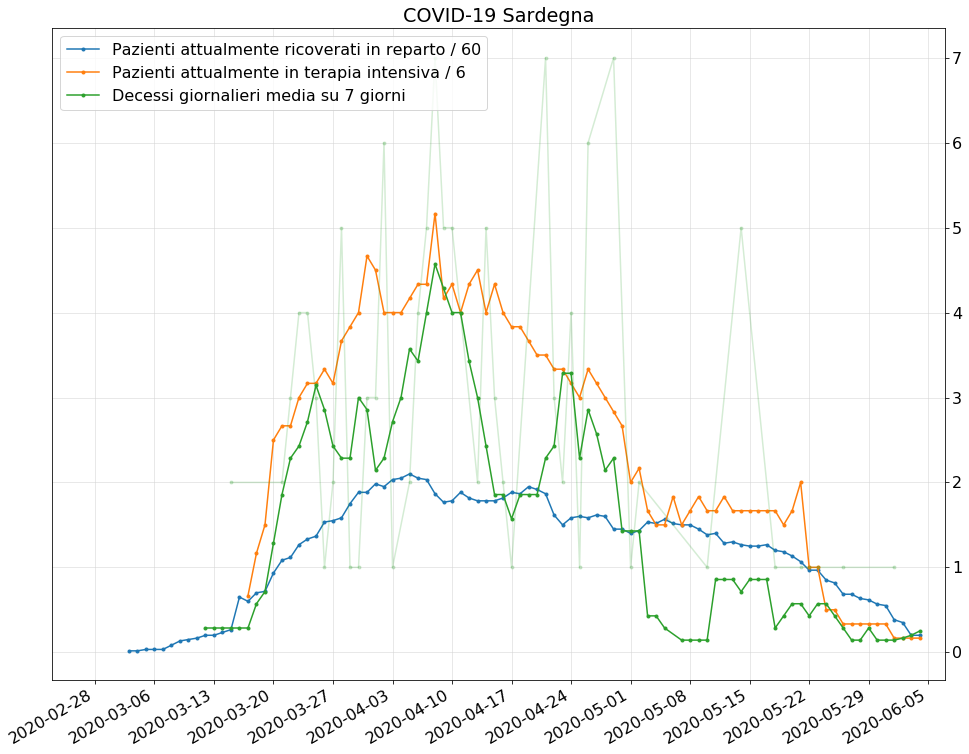

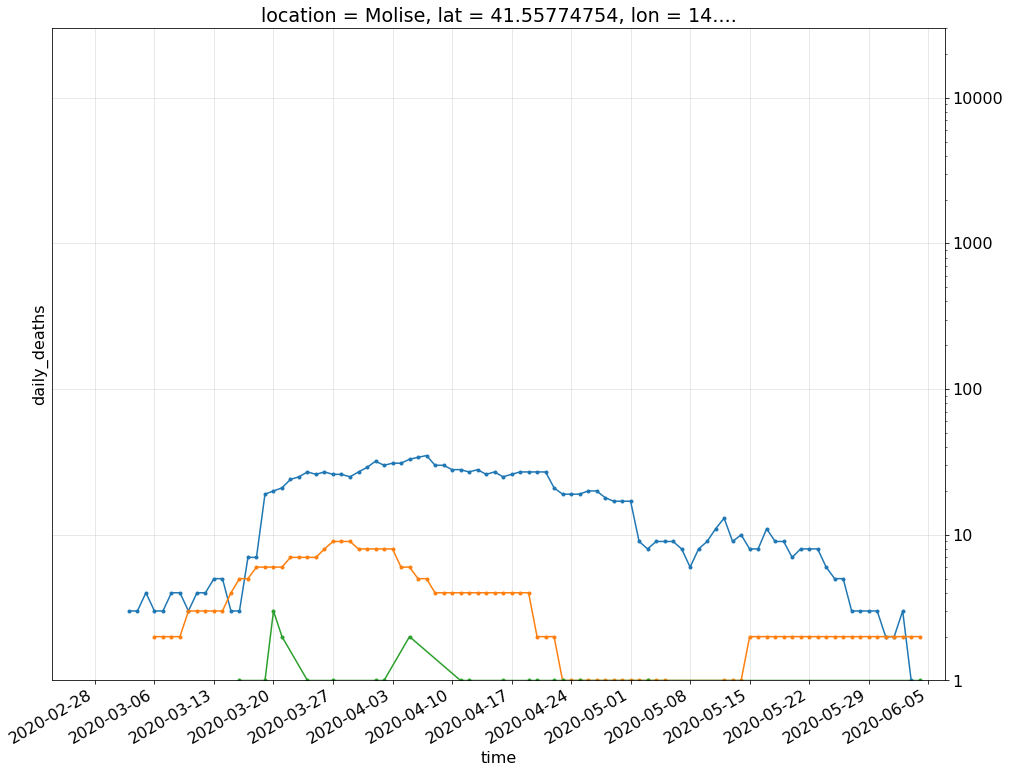

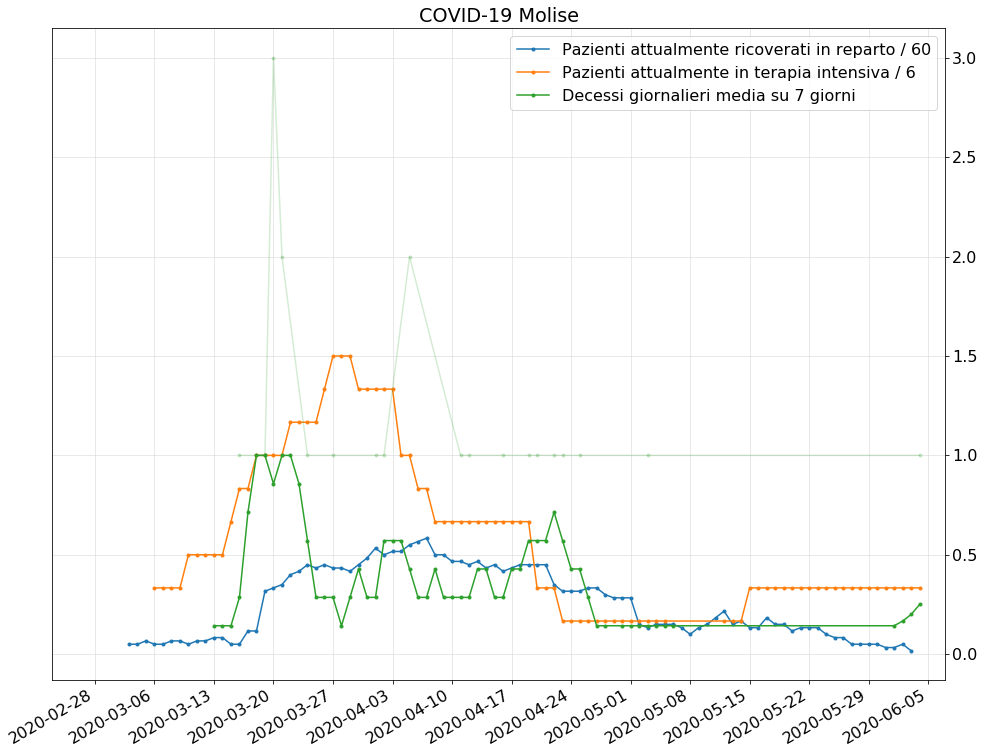

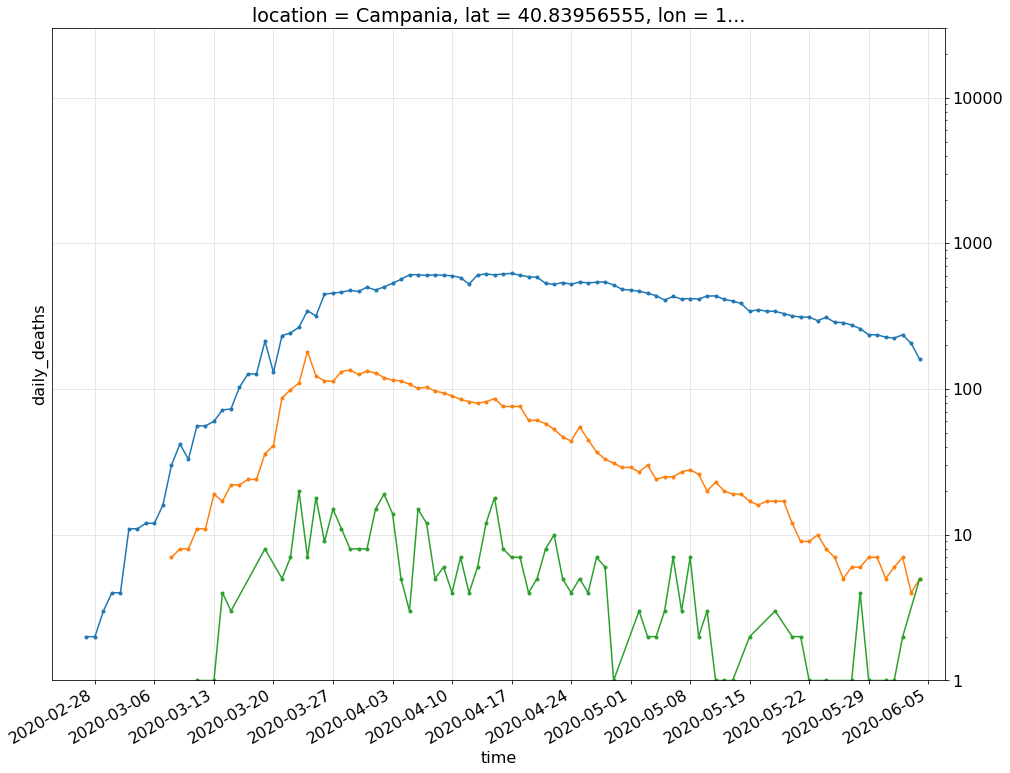

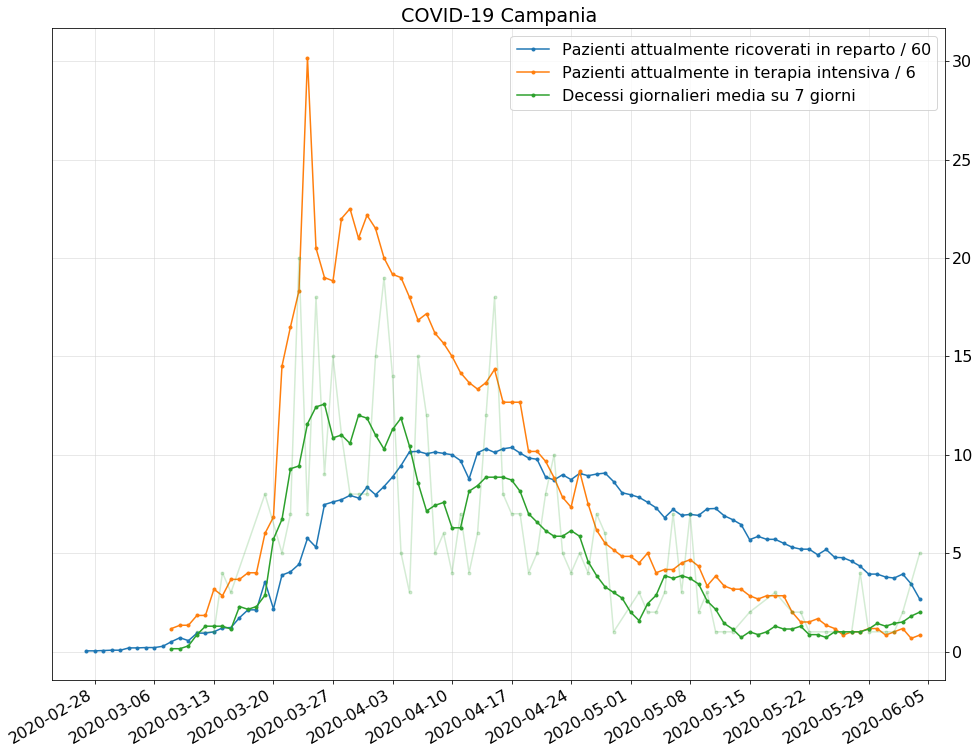

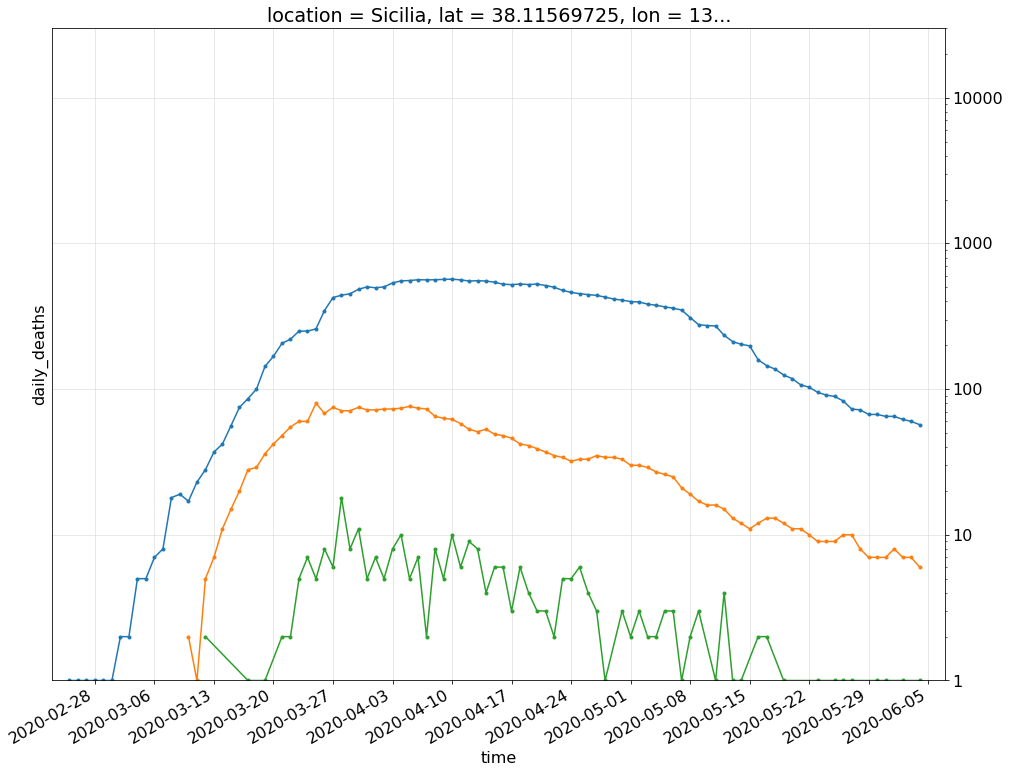

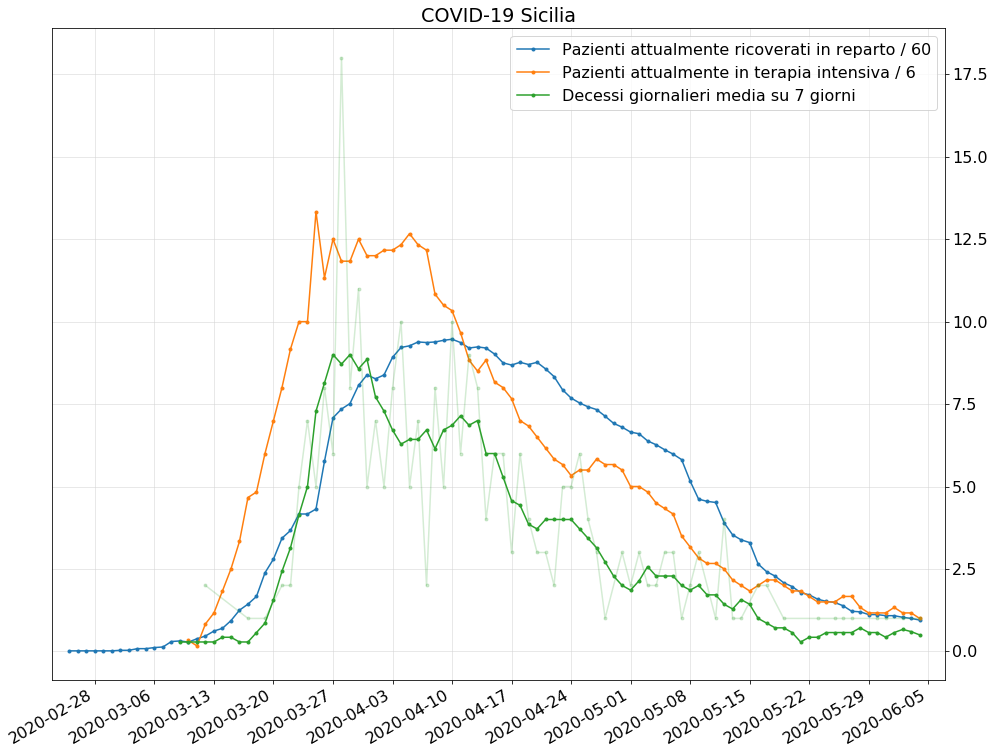

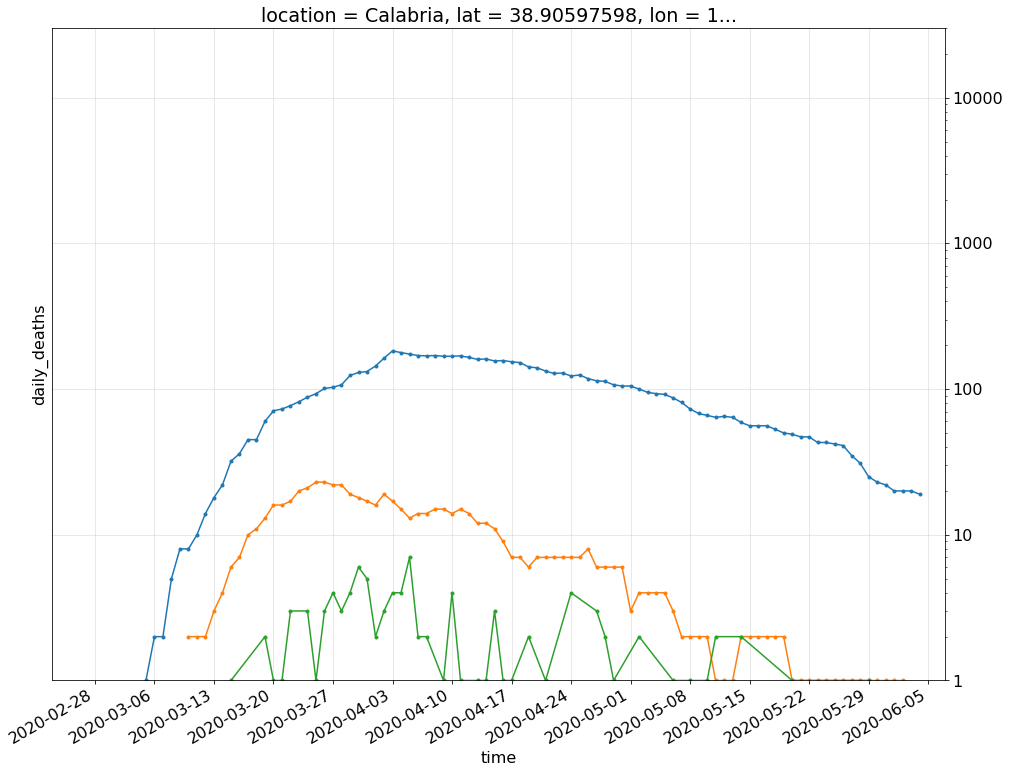

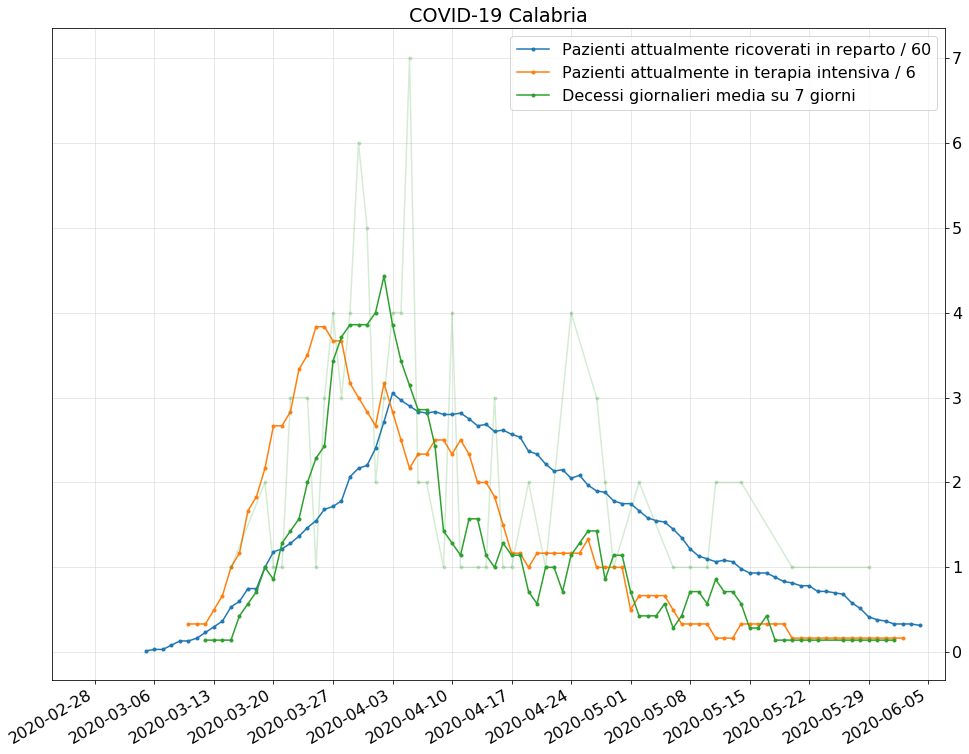

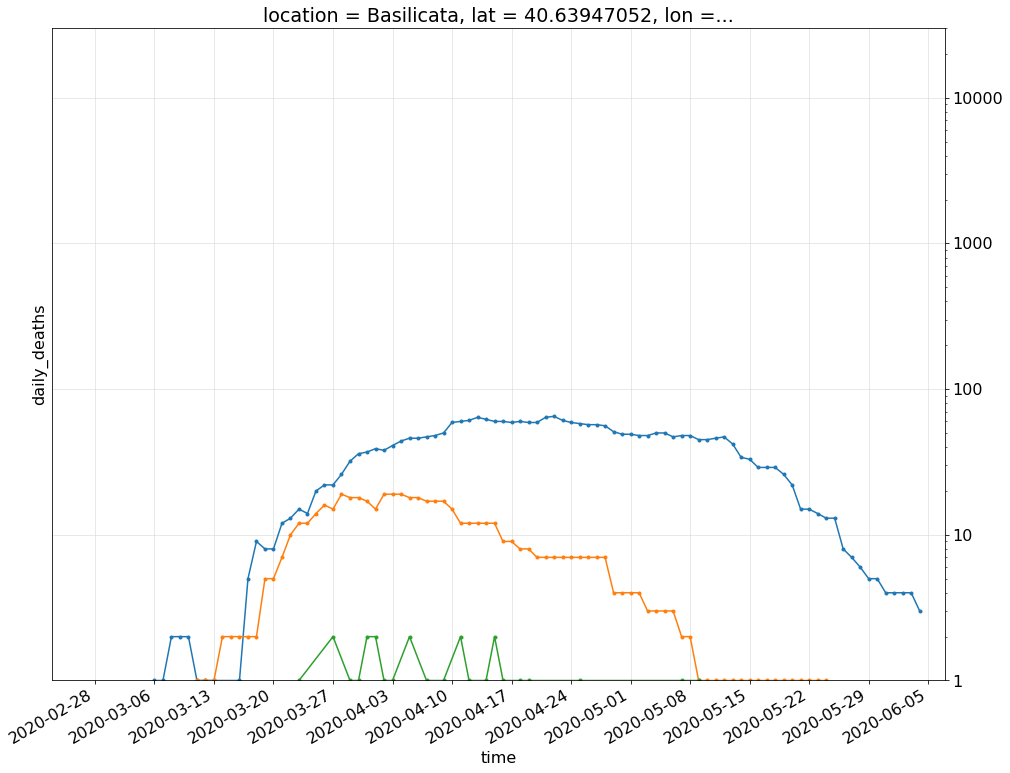

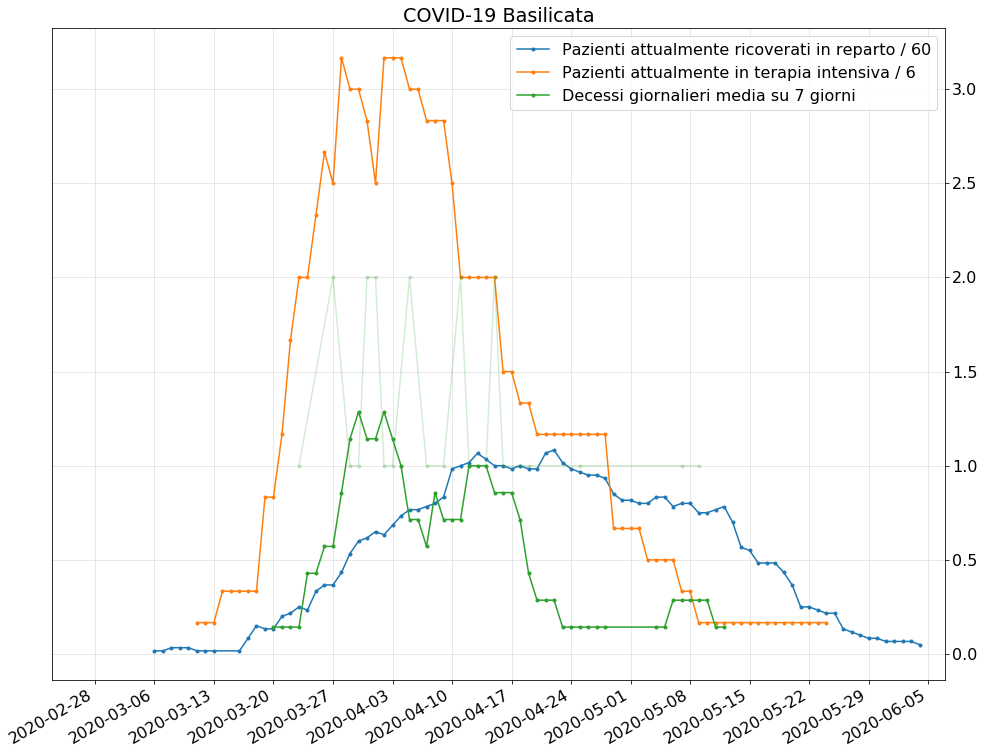

In [53]:
for region in REGIONS:
    fit_kinds = region_fits[region]
    ds_region = ds_italy_regions.sel(location=region)
    
    _, ax = plt.subplots(1, subplot_kw={'xlim': XLIM})
    ax.set(yscale='log', ylim=(1, 30000)) 
    ax.set_title(f'COVID-19 {region}')
    ax.yaxis.tick_right()
    ax.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax.xaxis.grid(color='lightgrey', linewidth=0.5)

    for (kind, fitsk), color in zip(fit_kinds.items(), PALETTE_ONE):
        label = LABEL[kind]
        covid19.plot.plot_data(ax, ds_region[kind], label=label, color=color)
        #for fit in fitsk:
        #    covid19.plot.plot(ax, ds_region[kind], fit, color=color, date_interval=7, add_diff=False)

    _, ax = plt.subplots(1, subplot_kw={'xlim': XLIM})
    ax.yaxis.tick_right()
    ax.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax.xaxis.grid(color='lightgrey', linewidth=0.5)

#    covid19.plot.plot_data(ax, data[region]['variazione_deaths_4'], label=label, color=color, alpha=0.5)
    for (kind, fitsk), color in zip(fit_kinds.items(), PALETTE_ONE):
        ratio = RATIO[kind]
        label = LABEL[kind] + ('' if ratio == 1 else f' / {ratio}')
        if kind == 'daily_deaths':
            covid19.plot.plot_data(ax, ds_region[kind] / RATIO[kind], color=color, alpha=0.2)
            covid19.plot.plot_data(ax, ds_region[kind].rolling({'time': 7}, center=True, min_periods=1).mean() / RATIO[kind], label=label + ' media su 7 giorni', color=color)
        else:
            covid19.plot.plot_data(ax, ds_region[kind] / RATIO[kind], label=label, color=color)
    ax.set_title(f'COVID-19 {region}')
    ax.set(xlabel="", ylabel="")
    ax.legend()


In [ ]:
rr = r.sel(time=slice('2020-03-15', None))

cop = rr['cases'].diff('time') / rr['current_cases'] * 100

ax = covid19.plot.plot_xarray(cop.rolling({'time': 6}, center=True).mean(), hue='location')
ax.set(ylim=(0, 5))
_ = ax.legend()

In [ ]:
ax = covid19.plot.scatter_xarray(rr['cases'].diff('time') / rr['current_cases'] * 100, rr['tests'].diff('time') / rr['current_cases'], window=7)
_ = ax.set(xlim=(0, 5))

In [ ]:
rr = r.sel(location=['Italy / Lombardia', 'Italy / P.A. Trento', 'Italy / Marche', 'Italy / Piemonte', 'Italy / Emilia-Romagna', 'Italy / Liguria', 'Italy / P.A. Bolzano', 'Italy / Lazio'], time=slice('2020-04-01', None))
ax = covid19.plot.scatter_xarray(rr['cases'].diff('time') / rr['current_cases'] * 100, (rr['current_severe'] + rr['current_critical']) / rr['current_cases'] * 100, window=7)
_ = ax.set(xlim=(0, None), ylim=(0, None))

In [ ]:
rr = r.sel(location=['Italy / Lombardia', 'Italy / P.A. Trento', 'Italy / Marche', 'Italy / Piemonte', 'Italy / Emilia-Romagna', 'Italy / Liguria', 'Italy / Veneto', 'Italy / Lazio', 'Italy / Umbria'], time=slice('2020-04-01', None))
ax = covid19.plot.scatter_xarray(rr['current_severe'] / rr['current_cases'] * 100, rr['cases'].diff('time') / rr['tested'].diff('time') * 100, window=7)
_ = ax.set(xlim=(5, 40), ylim=(0, 20))
